# Preambule

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import javabridge
import bioformats as bf
javabridge.start_vm(class_path=bf.JARS)
from collections import OrderedDict
import pandas as pd
from scipy.stats import distributions as dst
import numpy as np

%config Completer.use_jedi = False

from matplotlib.patches import Rectangle

omeTag = "http://www.openmicroscopy.org/Schemas/OME/2016-06"

def printRecur(root, maxLevel=np.inf, stoppingCrit=None):
    """Recursively prints the tree."""
    global level
    try: Levels[level] += 1
    except: pass
    if stoppingCrit is not None:
        if stoppingCrit(Levels):
            return None
    title = root.tag.title().lower().replace(omeTag.lower(),"").replace("{}","")
    txt = root.text
    if txt is None: txt = ""
    else: txt =  ": "+txt
    count = ".".join(Levels.astype(int).astype(str))#.rstrip(".0")
    isplit = count.find(".0")
    if isplit>0:
        count = count[:isplit]
    count += (10-len(count))*" "
    print (count, end="")
    print (' '*4*level,title,txt)
    level += 1
    if level<=maxLevel:
        for elem in root:
            printRecur(elem, maxLevel=maxLevel,stoppingCrit=stoppingCrit)
    level -= 1
    Levels[level+1:] = 0

from sys import path as syspath
from os.path import expanduser
syspath.append(expanduser("~/Seafile/functions/"))
from general_functions import autocorr, tally

from general_functions import moving_average

In [2]:
# def filterF(x,th=1,h=1,mode="low-pass"):
#     if mode=="low-pass":  out =    1/(th**2+x**2)
#     if mode=="high-pass": out = x**2/(th**2+x**2)
#     if h!=1: out = out**h
#     return out

# def FFTFilter(trace1, th=1, h=1, freq=1, mode="low-pass", plotPwSOnly=False):
#     offset = trace1.mean()
#     trace1 -= offset
#     dt  = 1./freq
#     FTs = np.fft.fft(trace1)
#     N   = len(trace1)
#     freqs = np.fft.fftfreq(N,dt)
#     FAs = np.abs(FTs)
#     PowerSpectrum = FAs**2/(1/dt)**2
#     assert np.abs(np.sum(PowerSpectrum)*freqs[1]/(np.sum(trace1**2)*dt)-1) < 1e-8
#     if plotPwSOnly:
#         Nshow = N//2
#         plt.plot(freqs[:Nshow],PowerSpectrum[:Nshow])
#         plt.yscale('log')
#         plt.xscale('log')
#         plt.twinx()
#         plt.plot(freqs[:Nshow],filterF(freqs[:Nshow],th=th,h=h,mode=mode),"r--")
#     filteredFT = FTs*filterF(freqs,th=th,h=h,mode=mode)**.5
#     filteredTrace = np.real_if_close(np.fft.ifft(filteredFT))+offset
#     return filteredTrace

## Parse metadata

In [3]:
filename = "Experiment30.lif"

rdr = bf.ImageReader("./data/"+filename, perform_init=True)
md = bf.get_omexml_metadata("./data/"+filename)
xml = bf.OMEXML(md)
Nimages = xml.get_image_count()

In [4]:
%%time
FirstFrames = []
mdf = []
for i in range(Nimages):
    im = xml.image(index=i)
    tmp = OrderedDict([(attrib,getattr(im,attrib)) for attrib in ["Name","AcquisitionDate"]])
    for dim in "XYTCZ":
        tmp[dim] = getattr(im.Pixels, "Size"+dim)
    mdf += [tmp]
    FirstFrames += [rdr.read(series=i, rescale=False,t=0)]

mdf = pd.DataFrame(mdf)

try:
    mdf["AcquisitionDate"] = pd.to_datetime(mdf["AcquisitionDate"])
except:
    pass

mdf#.loc[:,["X","Y","T","inferedTimes"]]

CPU times: user 1.57 s, sys: 92.8 ms, total: 1.67 s
Wall time: 1.71 s


Name     AcquisitionDate     X     Y     T  C  Z
0    Image006 2019-08-27 09:44:57  1024  1024     1  1  1
1    Image010 2019-08-27 09:49:28  1024  1024     1  1  1
2    Image012 2019-08-27 09:50:10  1024  1024     1  1  1
3   Series013 2019-08-27 09:50:40   512   512  7583  1  1
4    Image017 2048-03-12 10:41:23  1024  1024     1  1  1
5    Image018 2019-08-27 11:04:23  1024  1024     1  1  1
6   Series019 2019-08-27 11:05:13   512   512  2037  1  1
7    Image021 2019-08-27 11:25:48  1024  1024     1  1  1
8   Series022 2048-03-12 11:03:52  1024  1024     1  1  1
9   Series023 2019-08-27 11:26:47   512   512   984  1  1
10  Series027 2019-08-27 11:42:04   512   512   117  1  1
11  Series029 2019-08-27 11:43:54   512  8192    10  1  1
12  Series031 2019-08-27 11:45:27   512   512   515  1  1
13   Image033 2019-08-27 11:50:31   512  8192     1  1  1
14  Series034 2019-08-27 11:51:18   512  8000    10  1  1
15  Series035 2019-08-27 11:51:58   512  8000    10  1  1
16  Series036 2019-08-27 11:52:19   512  8000    10  1  1
17  Series037 2019-08-27 11:52:40   512  8000    10  1  1
18  Series038 2019-08-27 11:53:20   512   512   350  1  1
19  Series039 2019-08-27 11:58:35   512  8000    10  1  1
20  Series040 2019-08-27 11:58:57   512  8000    10  1  1
21  Series041 2019-08-27 11:59:19   512  8000    10  1  1
22  Series042 2019-08-27 11:59:56   512   512  1874  1  1
23  Series043 2019-08-27 12:24:31   512  8000    10  1  1
24  Series044 2019-08-27 12:24:52   512  8000    10  1  1
25  Series045 2019-08-27 12:25:14   512  8000    10  1  1
26   Image047 2019-08-27 12:29:13  1024  1024     1  1  1
27  Series048 2019-08-27 12:30:18   512   512   543  1  1
28  Series050 2019-08-27 12:35:37   512  8000    10  1  1
29  Series051 2019-08-27 12:35:58   512  8000    10  1  1
30  Series052 2019-08-27 12:36:21   512  8000    10  1  1
31  Series053 2019-08-27 12:36:54   512   512    10  1  1
32  Series054 2019-08-27 12:37:19   512  8000    10  1  1
33  Series055 2019-08-27 12:38:03   512  8000    10  1  1
34  Series056 2019-08-27 12:38:36   512   512   430  1  1
35  Series058 2019-08-27 12:44:34   512   512     9  1  1
36  Series059 2019-08-27 12:44:55   512  8000    10  1  1
37  Series060 2019-08-27 12:45:17   512  8000    10  1  1
38  Series061 2019-08-27 12:45:38   512  8000    10  1  1
39  Series062 2019-08-27 12:46:09   512   512   351  1  1
40  Series063 2019-08-27 12:51:09   512  8000    10  1  1
41  Series064 2019-08-27 12:51:32   512  8000    10  1  1
42  Series065 2019-08-27 12:51:54   512  8000    10  1  1
43  Series066 2019-08-27 12:52:37   512   512   412  1  1
44  Series067 2019-08-27 12:58:14   512  8000    10  1  1
45  Series068 2019-08-27 12:58:37   512  8000    10  1  1
46  Series069 2019-08-27 12:58:59   512  8000    10  1  1
47  Series070 2019-08-27 12:59:38   512   512    38  1  1
48  Series071 2019-08-27 13:00:44   512  8000    10  1  1
49  Series072 2019-08-27 13:01:27   512   512  2044  1  1
50  Series073 2019-08-27 13:28:04   512  8000    10  1  1
51  Series074 2019-08-27 13:28:28   512  8000    10  1  1
52  Series075 2019-08-27 13:28:50   512  8000    10  1  1
53  Series076 2019-08-27 13:29:11   512  8000    10  1  1
54   Image078 2019-08-27 13:34:53  1024  1024     1  1  1
55  Series079 2019-08-27 13:35:33  1024   256    10  1  1
56  Series080 2019-08-27 13:35:42   512   512  7927  1  1
57   Image083 2019-08-27 14:47:13  1024  1024     1  1  1
58  Series084 2048-03-12 14:24:45  1024  1024     1  1  1
59  Series085 2019-08-27 14:48:10   512   512  7916  1  1

In [5]:
def getTimes(idx_):
    Pixels = xml.image(index=idx_).Pixels
    nPlanes = Pixels.get_plane_count()
    return np.array([Pixels.Plane(i).DeltaT for i in range(nPlanes)])

In [6]:
# tmp = pd.Series((mdf["Y"]/mdf["X"]>3).values)
# # tmp.name="LineScan"
# # mdf.join(tmp).sort_values("Y", ascending=False)
# mdf["LineScane"] = tmp
# del tmp

# Parse Annotations

In [7]:
import xml.etree.ElementTree as ET

In [8]:
realXML = xml.to_xml()

with open("tmp.xml","w") as f:
    f.write(realXML)
tree = ET.ElementTree(file="tmp.xml")
root = tree.getroot()

annotations = root[-1]

allFeatures = np.unique([" ".join(elem.text.split()[1:]) for elem in annotations.iter("{%s}"%omeTag+"Key")])

len(allFeatures)

205

In [9]:
%%time
features = pd.DataFrame(index=mdf.Name,columns=allFeatures)

for elem in annotations.iter("{%s}"%omeTag + "OriginalMetadata"):
    keys   = elem.findall(   "{%s}"%omeTag + "Key")
    values = elem.findall(   "{%s}"%omeTag + "Value")
    assert len(keys)==len(values)
    for k,v in zip(keys,values):
        name = k.text.split()[0]
        feature = " ".join(k.text.split()[1:])
        features.loc[name, feature] = v.text

CPU times: user 6.18 s, sys: 19.3 ms, total: 6.2 s
Wall time: 6.21 s


In [10]:
len(features.columns)

205

In [11]:
for ft in allFeatures:
    try:
        features[ft] = pd.to_numeric(features[ft], downcast="float")
    except:
        continue
        
    try:
        v = features[ft]
        vint = pd.to_numeric(v, downcast="integer")
        if np.sum((vint-v)**2)==0:
            features[ft] = vint
    except:
        continue

In [12]:
constFeatures = OrderedDict([(ft,features[ft].values[0]) for ft in allFeatures if len(features[ft].unique())==1])

In [13]:
# assert all numerical constanct values do NOT have NANs
assert np.all([np.isfinite(features[ft].values) for ft in constFeatures if type(constFeatures[ft])!=str])

In [14]:
varFeatures = [ft for ft in allFeatures if ft not in constFeatures]

features = features[varFeatures]

len(features.columns)

33

In [15]:
nameAlias = OrderedDict([(ft,ft.split("|")[-1].replace(" ","_").replace("#","")) for ft in varFeatures])

In [16]:
lineAvg = features.rename(columns=nameAlias)['nAverageLine_1']
# .idxsort()

In [17]:
mdf = mdf.join(lineAvg,on="Name")

In [18]:
# del mdf["TimeUnit"]

In [19]:
# addColls = ["DimensionDescription|Length", "DimensionDescription|Unit"]
# renameColls = {c:c.replace("DimensionDescription|","Time") for c in addColls}
# mdf = mdf.join(features[addColls].rename(renameColls,axis="columns"),on="Name")

In [20]:
tmp = features.rename(nameAlias,axis="columns")["csScanMode_1"].copy()
mdf["ScanMode"] = tmp.values

In [21]:
mdf

Name     AcquisitionDate     X     Y     T  C  Z  nAverageLine_1  \
0    Image006 2019-08-27 09:44:57  1024  1024     1  1  1             128   
1    Image010 2019-08-27 09:49:28  1024  1024     1  1  1             128   
2    Image012 2019-08-27 09:50:10  1024  1024     1  1  1             128   
3   Series013 2019-08-27 09:50:40   512   512  7583  1  1               8   
4    Image017 2048-03-12 10:41:23  1024  1024     1  1  1            1024   
5    Image018 2019-08-27 11:04:23  1024  1024     1  1  1             128   
6   Series019 2019-08-27 11:05:13   512   512  2037  1  1               8   
7    Image021 2019-08-27 11:25:48  1024  1024     1  1  1             128   
8   Series022 2048-03-12 11:03:52  1024  1024     1  1  1             128   
9   Series023 2019-08-27 11:26:47   512   512   984  1  1               8   
10  Series027 2019-08-27 11:42:04   512   512   117  1  1               4   
11  Series029 2019-08-27 11:43:54   512  8192    10  1  1               4   
12  Series031 2019-08-27 11:45:27   512   512   515  1  1               8   
13   Image033 2019-08-27 11:50:31   512  8192     1  1  1               4   
14  Series034 2019-08-27 11:51:18   512  8000    10  1  1               4   
15  Series035 2019-08-27 11:51:58   512  8000    10  1  1               4   
16  Series036 2019-08-27 11:52:19   512  8000    10  1  1               4   
17  Series037 2019-08-27 11:52:40   512  8000    10  1  1               4   
18  Series038 2019-08-27 11:53:20   512   512   350  1  1               8   
19  Series039 2019-08-27 11:58:35   512  8000    10  1  1               4   
20  Series040 2019-08-27 11:58:57   512  8000    10  1  1               4   
21  Series041 2019-08-27 11:59:19   512  8000    10  1  1               4   
22  Series042 2019-08-27 11:59:56   512   512  1874  1  1               8   
23  Series043 2019-08-27 12:24:31   512  8000    10  1  1               4   
24  Series044 2019-08-27 12:24:52   512  8000    10  1  1               4   
25  Series045 2019-08-27 12:25:14   512  8000    10  1  1               4   
26   Image047 2019-08-27 12:29:13  1024  1024     1  1  1             128   
27  Series048 2019-08-27 12:30:18   512   512   543  1  1               8   
28  Series050 2019-08-27 12:35:37   512  8000    10  1  1               4   
29  Series051 2019-08-27 12:35:58   512  8000    10  1  1               4   
30  Series052 2019-08-27 12:36:21   512  8000    10  1  1               4   
31  Series053 2019-08-27 12:36:54   512   512    10  1  1               8   
32  Series054 2019-08-27 12:37:19   512  8000    10  1  1               8   
33  Series055 2019-08-27 12:38:03   512  8000    10  1  1               4   
34  Series056 2019-08-27 12:38:36   512   512   430  1  1               8   
35  Series058 2019-08-27 12:44:34   512   512     9  1  1               4   
36  Series059 2019-08-27 12:44:55   512  8000    10  1  1               4   
37  Series060 2019-08-27 12:45:17   512  8000    10  1  1               4   
38  Series061 2019-08-27 12:45:38   512  8000    10  1  1               4   
39  Series062 2019-08-27 12:46:09   512   512   351  1  1               8   
40  Series063 2019-08-27 12:51:09   512  8000    10  1  1               4   
41  Series064 2019-08-27 12:51:32   512  8000    10  1  1               4   
42  Series065 2019-08-27 12:51:54   512  8000    10  1  1               4   
43  Series066 2019-08-27 12:52:37   512   512   412  1  1               8   
44  Series067 2019-08-27 12:58:14   512  8000    10  1  1               4   
45  Series068 2019-08-27 12:58:37   512  8000    10  1  1               4   
46  Series069 2019-08-27 12:58:59   512  8000    10  1  1               4   
47  Series070 2019-08-27 12:59:38   512   512    38  1  1               8   
48  Series071 2019-08-27 13:00:44   512  8000    10  1  1               4   
49  Series072 2019-08-27 13:01:27   512   512  2044  1  1               8   
50  Series073 2019-08-27 13:28:04   512  8000    10  1  1               4   
51  S

In [22]:
# appFreq = mdf['T']/mdf["TimeLength"]
# appFreq[mdf["TimeUnit"]=="m"] = np.nan
# appFreq[~np.isfinite(appFreq)] = np.nan
# mdf.join(pd.DataFrame({"apparentFreq":appFreq})).query("ScanMode=='xt'")

In [326]:
# from importlib import reload
# reload(plt)

In [327]:
# def fit1(t,y):
#     dt = np.mean(np.diff(t))
#     p0 = guessPars(t,y)
#     print (p0)
#     if not p0: 
#         return None
#     p0 = p0[:-1]
#     t0 = p0[2]
#     print (p0)
#     crit = y-myLogNorm(t,*p0)>10
#     if not np.any(crit): 
#         iStop = len(y)
#     else:
#         iStop = np.where(crit)[0][0]
#     p = curve_fit(myLogNorm,t[:iStop],y[:iStop],p0=p0,
#                   bounds=np.array([
#                       (0,np.inf),
#                       (-np.inf,np.inf),
#                       (t0-.1,t0+.1),
#                       (.05,.14),
#                       (0.7,2),
#                   ])[:len(p0)].T

#                  )[0]
#     return p

In [328]:
# def fitMore(t,y,nPeaks = 10):
#     yr = y.copy()
#     ps = []
#     for i in range(nPeaks):
#         yr -= multiFun(t,ps)
#         p = fit1(t,yr)
#         if p is not None:
#             ps += [p]
#         else:
#             break
#     return ps

In [329]:
# def fit(t,y,ax=None,nPeaks=30):
#     if ax:
#         ax.plot(t,y,lw=.5)
#     iBegin = 0
#     score = np.sum((y-y.mean())**2)
#     ps = []
#     for ip in range(nPeaks):
#         if iBegin>len(y)-10:
#             break
#         y0 = multiFun(t,ps)
#         tr,yr = t[iBegin:],(y-y0)[iBegin:]
#         p0 = guessPars(tr,yr)
#         if not p0: break
#         p0 = p0[:-1]
#         if ax: ax.plot(t,myLogNorm(t,*p0),"lightgrey",lw=.6)
#         crit = yr-myLogNorm(tr,*p0)>20
#         if not np.any(crit): 
#             iStop = len(y)
#         else:
#             iStop = np.where(crit)[0][0] + iBegin
#         try:
#             t0 = p0[2]
#             p = curve_fit(myLogNorm,tr[:iStop],yr[:iStop],p0=p0,
#                           bounds=np.array([
#                               (6,np.inf),
#                               (-np.inf,np.inf),
#                               (t0-.05,t0+.05),
#                               (.05,.14),
#                               (0.8,2),
#                           ])[:len(p0)].T
                          
#                          )[0]
#         except:
#             iBegin += 10
#             continue
#         ps += [p]
#         iBegin = iStop+1
#         y1 = multiFun(t,ps)
#         newScore = np.sum((y-y1)**2)
#         dScore = newScore-score
#         if dScore>-30:
#             ps = ps[:-1]
#             if ax: ax.plot(t,y0+myLogNorm(t,*p),color="grey")
#             continue
#         score=newScore
#         if ax: ax.plot(t,y0+myLogNorm(t,*p))
            
#     return ps

# Mess 

In [330]:
from scipy.stats import distributions as dst

In [331]:
from scipy.optimize import curve_fit,minimize,basinhopping

In [332]:
def myLogNorm(t,Ampl,offset,loc,scale=.1,s=1):
    yd = dst.lognorm.pdf(t,loc=loc,scale=scale,s=s)
    yd = Ampl*yd/yd.max()+offset
    return yd

In [333]:
def guessPars(t,x):
    x0 = np.percentile(x,5)
    crit = x>x0+20
    if np.any(crit):
        iloc = np.where(crit)[0][0]
    else:
        iloc = np.argmax(x)
#     if iloc<0:iloc=0
#     x0 = np.mean(x[:iloc])
    loc = t[iloc]
    imax = iloc+np.argmax(x[iloc:min(len(x),iloc+10)])
    xmaxAvg = x[max(imax-2,0):min(len(x),imax+10)].mean()
    if xmaxAvg<np.percentile(x,10):
        return False
    Ampl = xmaxAvg-x0
    scale = .07
    s = 1.
    return Ampl,x0,loc,scale,s

In [493]:
def multiFun(t,ps):
    if len(ps)==0:
        return np.zeros_like(t)
    else:
        return np.sum([myLogNorm(t,*p) for p in ps], axis=0)

In [335]:
def firstOccurConseq(a_,conseq=1):
    a_=a_.copy()
    icc = np.where(a_)[0]
    if conseq==1:
        return icc[0]
    else:
        for i in range(conseq-1):
            try:
                icc = icc[:-1][np.diff(icc)==1]
            except:
                return -1
        return icc[0]

In [419]:
def Fit(t,y,ax=None,nPeaks=30,verbose=False, showFailed=True):
    if ax:
        ax.plot(t,y,lw=.5)
    iBegin = 0
    dt = np.diff(t).mean()
#     print (len(t),len(y))
    ps = []
    for ip in range(nPeaks):
        if iBegin>len(y)-10:
            break
        y0 = multiFun(t,ps)
#         if y0 = 0: y0 = y.mean()
        tr,yr = t[iBegin:],(y-y0)[iBegin:]
        p0 = guessPars(tr,yr)
        if not p0:
            if verbose: print ("could not guess, p0=",p0)
            break
        p0 = p0[:-1]
        crit = yr-myLogNorm(tr,*p0)>20
        try:    iStop = firstOccurConseq(crit,3)
        except: iStop = len(y)
        if iStop<0: 
            iStop = min(len(y),iBegin+1./dt)
        else:
            iStop += iBegin
        if iStop==iBegin:
            iStop = iBegin+int(.3/dt)
        iStop = min(len(y),iStop)
#         print (iBegin,iStop,len(y),len(t))
        if verbose: print (ip,iBegin,iStop,p0,t[iBegin],t[iStop-1])
        tr = tr[:iStop-iBegin]
        yr = yr[:iStop-iBegin]
#         ax.plot(tr,yr,lw=.7)
#         ax.plot(t,myLogNorm(t,*p0),"lightgrey",lw=.8)
        if ax: 
#             ax.plot(t[iBegin:iStop],myLogNorm(t[iBegin:iStop],*p0),"lightgrey",lw=.8)
            ax.plot(tr,multiFun(tr,ps+[p0]),"lightgrey",lw=.8)
        try:
            t0 = p0[2]
            p = curve_fit(myLogNorm,tr,yr,p0=p0,
                          bounds=np.array([
                              (6,np.inf),
                              (-np.inf,np.inf),
                              (t0-.05,t0+.05),
                              (.05,.2),
                              (0.8,2),
                          ])[:len(p0)].T 
                         )[0]
        except:
            if verbose: print ("something was off with fitting")
            iBegin += int(.1/dt)
            continue
#         print (p)
        score    = EvalModel([ ],t[:iStop], y[:iStop]-multiFun(t[:iStop],ps)-y.mean()*int(len(ps)==0))
        newScore = EvalModel([p],t[:iStop], y[:iStop]-multiFun(t[:iStop],ps))
#         score    = EvalModel([ ],tr,yr-yr.mean())
#         newScore = EvalModel([p],tr,yr)

        if newScore>score*.99:
            if verbose: print ("refused since score0 = %.1f and suggested score = %.1f"%(score,newScore))
            if ax and showFailed: ax.plot(tr,multiFun(tr,ps+[p]),color="grey")
            iBegin += int(.1/dt)
            continue
        if verbose: print ("accepted since score0 = %.1f and suggested score = %.1f"%(score,newScore))
        ps += [p]
        score=newScore
        if ax: ax.plot(t,y0+myLogNorm(t,*p))
#         iBegin = max(0,iStop - int(.5/dt))
        iBegin += int(.2/dt)
    return ps

In [337]:
def getSmoothPx(px,timeWindow,avgWindow=30):
    assert avgWindow%2==0
    twIndices = slice(*(np.where(times>=tl)[0][0] for tl in timeWindow))
    return moving_average(LineT[twIndices,px],avgWindow-1)[::avgWindow]

In [338]:
def getSmoothT(timeWindow,avgWindow=30):
    assert avgWindow%2==0
    twIndices = slice(*(np.where(times>=tl)[0][0] for tl in timeWindow))
    return moving_average(times[twIndices],avgWindow-1)[::avgWindow]

In [339]:
def EvalModel(ps,t,x):
    xf = multiFun(t,ps)
    return np.sum((x-xf)**2)

# Choose Series

In [385]:
idx = 17#np.where(features.index==ix)[0][0]
Name = mdf.loc[idx,"Name"]
dimensions = mdf.loc[idx,list("XYZCT")]
image = np.array([
            rdr.read(series=idx, rescale=False,t=t, ) for t in range(dimensions["T"])
        ])

In [386]:
Name, image.shape

('Series037', (10, 8000, 512))

In [387]:
times = getTimes(idx)
dt = np.diff(times).mean()
lineScaneMode = mdf.loc[idx,"ScanMode"]=="xt"
if lineScaneMode:
    LineT = np.vstack(image)
    dt = dt/len(image[0])
    times = np.arange(len(LineT))*dt

frequency = 1./dt

In [ ]:
%%time
plt.figure(figsize=(15,4))
plt.boxplot(LineT[::1000,:],showfliers=False);
plt.xticks([])

In [ ]:
mostVariableLines = np.argsort(LineT.std(axis=0))[::-1]

In [ ]:
mostVariableDiffLines = np.argsort(np.diff(LineT,axis=0).std(axis=0))[::-1]

In [391]:
t0 = 0
avgWindow = 30
pxAvg = 1

timeWindow = np.array([t0,t0+20])
twIndices = slice(*(np.where(times>=tl)[0][0] for tl in timeWindow))
smoothTime = moving_average(times[twIndices],avgWindow-1)[::avgWindow//2]
smoothLine = np.array([moving_average(line,avgWindow-1)[::avgWindow//2] for line in LineT[twIndices].T]).T
smoothAvgLine = smoothLine.reshape(len(smoothLine),LineT.shape[1]//pxAvg,pxAvg).mean(axis=-1)
offsets = np.percentile(smoothAvgLine,5,axis=0)
offsetM = np.array([offsets]*len(smoothAvgLine))
X = smoothAvgLine - offsetM

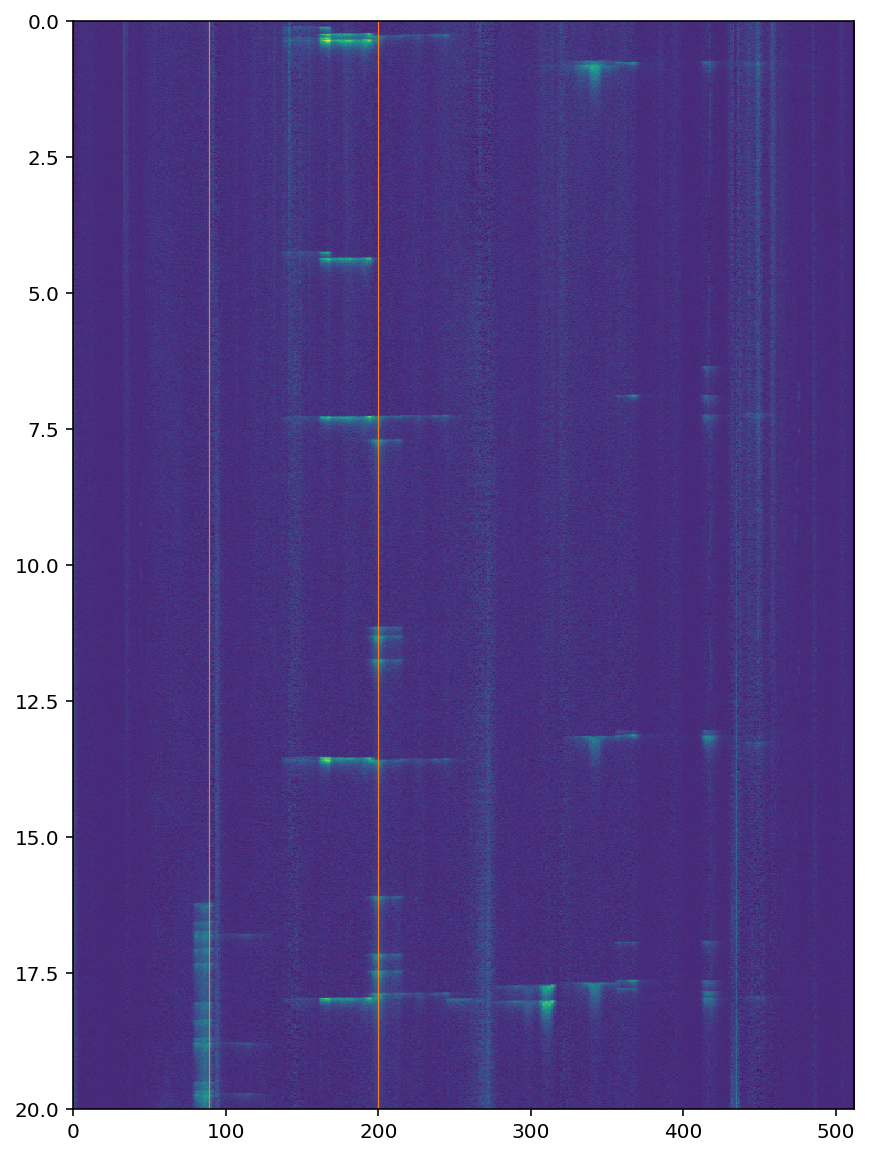

In [395]:
plt.figure(figsize=(7,10))
ax = plt.subplot(111)
ax.imshow(X,extent=(0,X.shape[1],timeWindow[1],timeWindow[0]), cmap="viridis")
ax.set_aspect("auto")
interesting = [89,200]
for px in interesting:
    ax.axvline(px,lw=.6,color="C1")

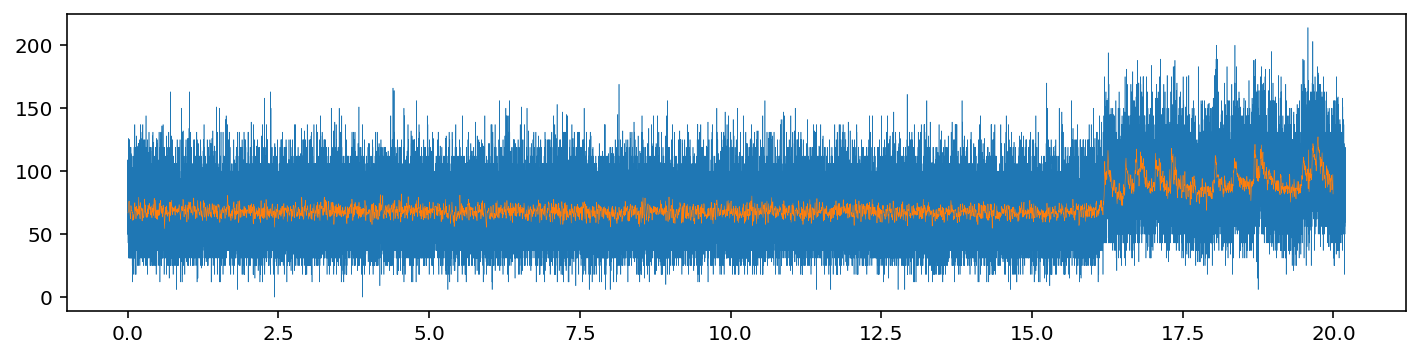

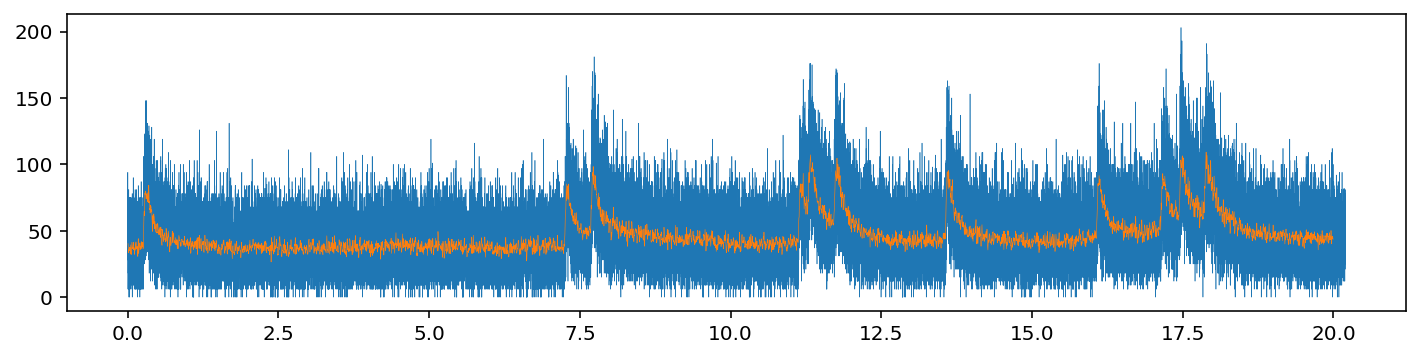

In [396]:
for iShow in interesting[:]:
    plt.figure(figsize=(12,6))
    ax = plt.subplot(211)
    t,x = times, LineT[:,iShow]
    ax.plot(t,x,lw=.3)
    t,x = smoothTime, smoothAvgLine[:,iShow]
    ax.plot(t,x,lw=.3)

In [503]:
def manyFit(t,x,verbose=False,toll=.1):
    var0 = x.var()
    xf = x.copy()
    PS_ = []
    for i in range(10):
        ps = Fit(t,xf,nPeaks=3)
        if not len(ps):
            print ("stopped because there was nothing else to find")
            break
        xf = xf-multiFun(t,ps)
        var1 = xf.var()
        dr2 = 1-var1/var0
        if dr2<toll:
            print ("stopped because the fve difference was too small: %f --> %f (%f)"%(var0,var1,dr2))
            break
        PS_ += ps
        print ("accepted because the fve difference was large enough: %f --> %f (%f)"%(var0,var1,dr2))
        var0 = var1
#         print (PR_)
    return PS_

accepted because the fve difference was large enough: 242.765004 --> 181.520782 (0.252278)
accepted because the fve difference was large enough: 181.520782 --> 24.804899 (0.863350)
accepted because the fve difference was large enough: 24.804899 --> 22.479015 (0.093767)
stopped because there was nothing else to find


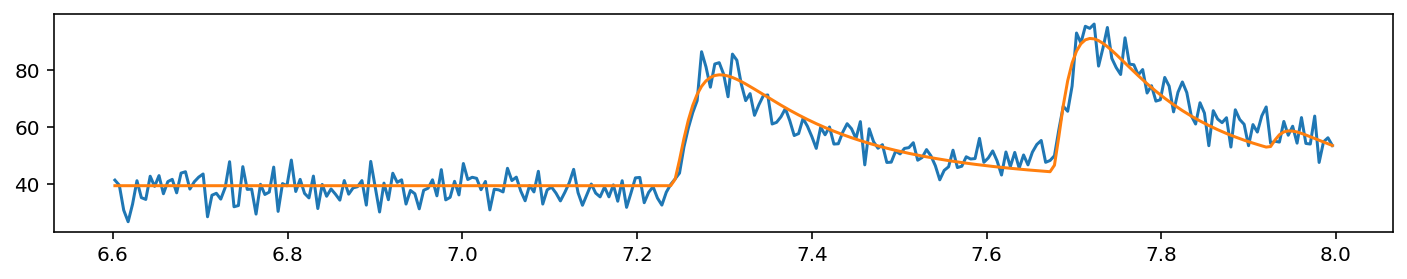

In [499]:
iShow = interesting[-1]
avgWindow = 20
t0 = 6.6
timeWindow = (t0,t0+DeltaT)
t,x = getSmoothT(timeWindow,avgWindow), getSmoothPx(iShow,timeWindow,avgWindow)

plt.figure(figsize=(12,2))
ax = plt.subplot(111)
ps = manyFit(t,x,True)
ax.plot(t,x)
ax.plot(t,multiFun(t,ps))

In [482]:
ps

[]

242.76500352772314 1.0 1.0
181.52078247325264 0.74772219980432 0.07707331785999047
24.804899410039038 0.10217658661499116 0.00892452625898034


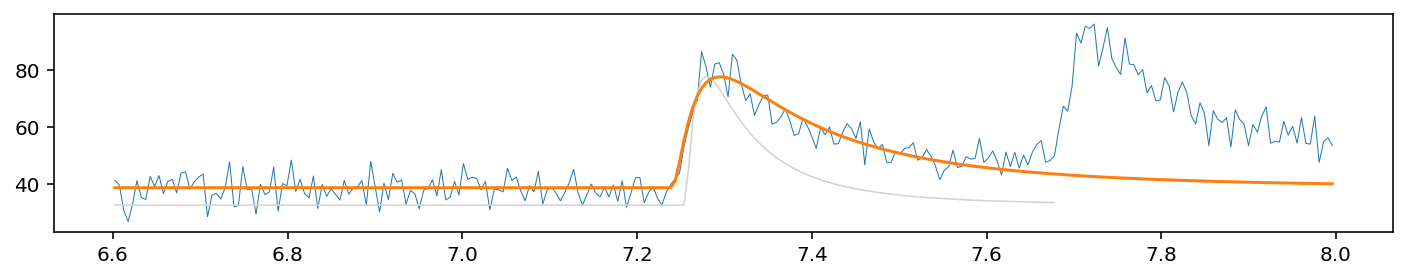

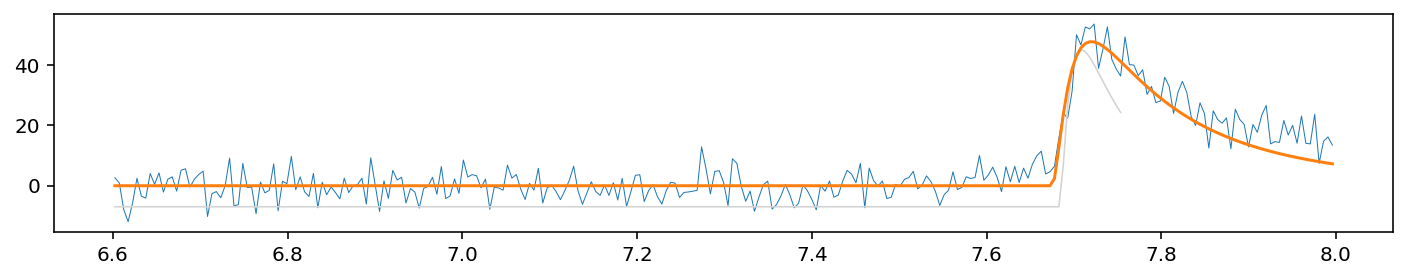

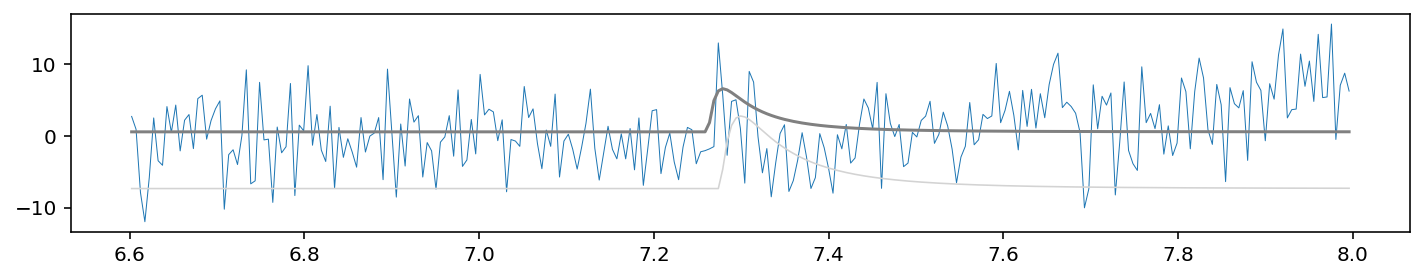

In [453]:
iShow = interesting[-1]
avgWindow = 20
t0 = 6.6
timeWindow = (t0,t0+DeltaT)
t,x = getSmoothT(timeWindow,avgWindow), getSmoothPx(iShow,timeWindow,avgWindow)
PS = []
for i in range(10):
    xf = x-multiFun(t,PS)
    print (xf.var(),xf.var()/x.var(), EvalModel(PS,t,x)/EvalModel([],t,x))
    plt.figure(figsize=(12,2))
    ax = plt.subplot(111)
    ps = Fit(t,xf,ax=ax,nPeaks=1)
    if len(ps): PS += ps
    else: break

stopped because the r2 difference was too small: 242.765004 --> 181.520782


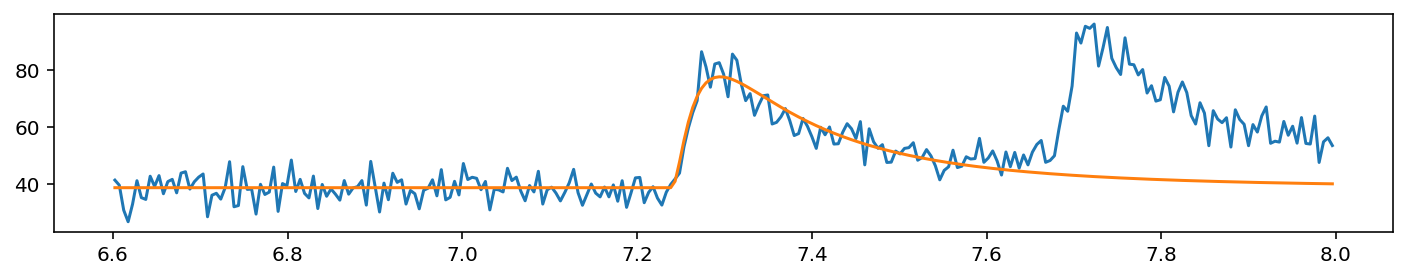

In [469]:
iShow = interesting[-1]
avgWindow = 20
t0 = 6.6
timeWindow = (t0,t0+DeltaT)
t,x = getSmoothT(timeWindow,avgWindow), getSmoothPx(iShow,timeWindow,avgWindow)

plt.figure(figsize=(12,2))
ax = plt.subplot(111)
ps = manyFit(t,x,True)
ax.plot(t,x)
ax.plot(t,multiFun(t,ps))

In [468]:
1-180/250

0.28

In [491]:
PS[timeWindow]

[]

In [492]:
multiFun(t,PS[timeWindow])

0.0

(6.0, 7.4)
accepted because the fve difference was large enough: 123.062066 --> 18.097324 (0.852941)
stopped because there was nothing else to find
(6.35, 7.75)
accepted because the fve difference was large enough: 198.309909 --> 16.869792 (0.914932)
stopped because there was nothing else to find
(6.699999999999999, 8.1)
accepted because the fve difference was large enough: 231.153051 --> 31.770380 (0.862557)
stopped because there was nothing else to find
(7.049999999999999, 8.45)
accepted because the fve difference was large enough: 177.568397 --> 26.567649 (0.850381)
stopped because there was nothing else to find
(7.399999999999999, 8.799999999999999)
accepted because the fve difference was large enough: 121.574426 --> 22.804074 (0.812427)
accepted because the fve difference was large enough: 22.804074 --> 21.290939 (0.066354)
stopped because there was nothing else to find
CPU times: user 26 s, sys: 1.01 s, total: 27 s
Wall time: 6.85 s


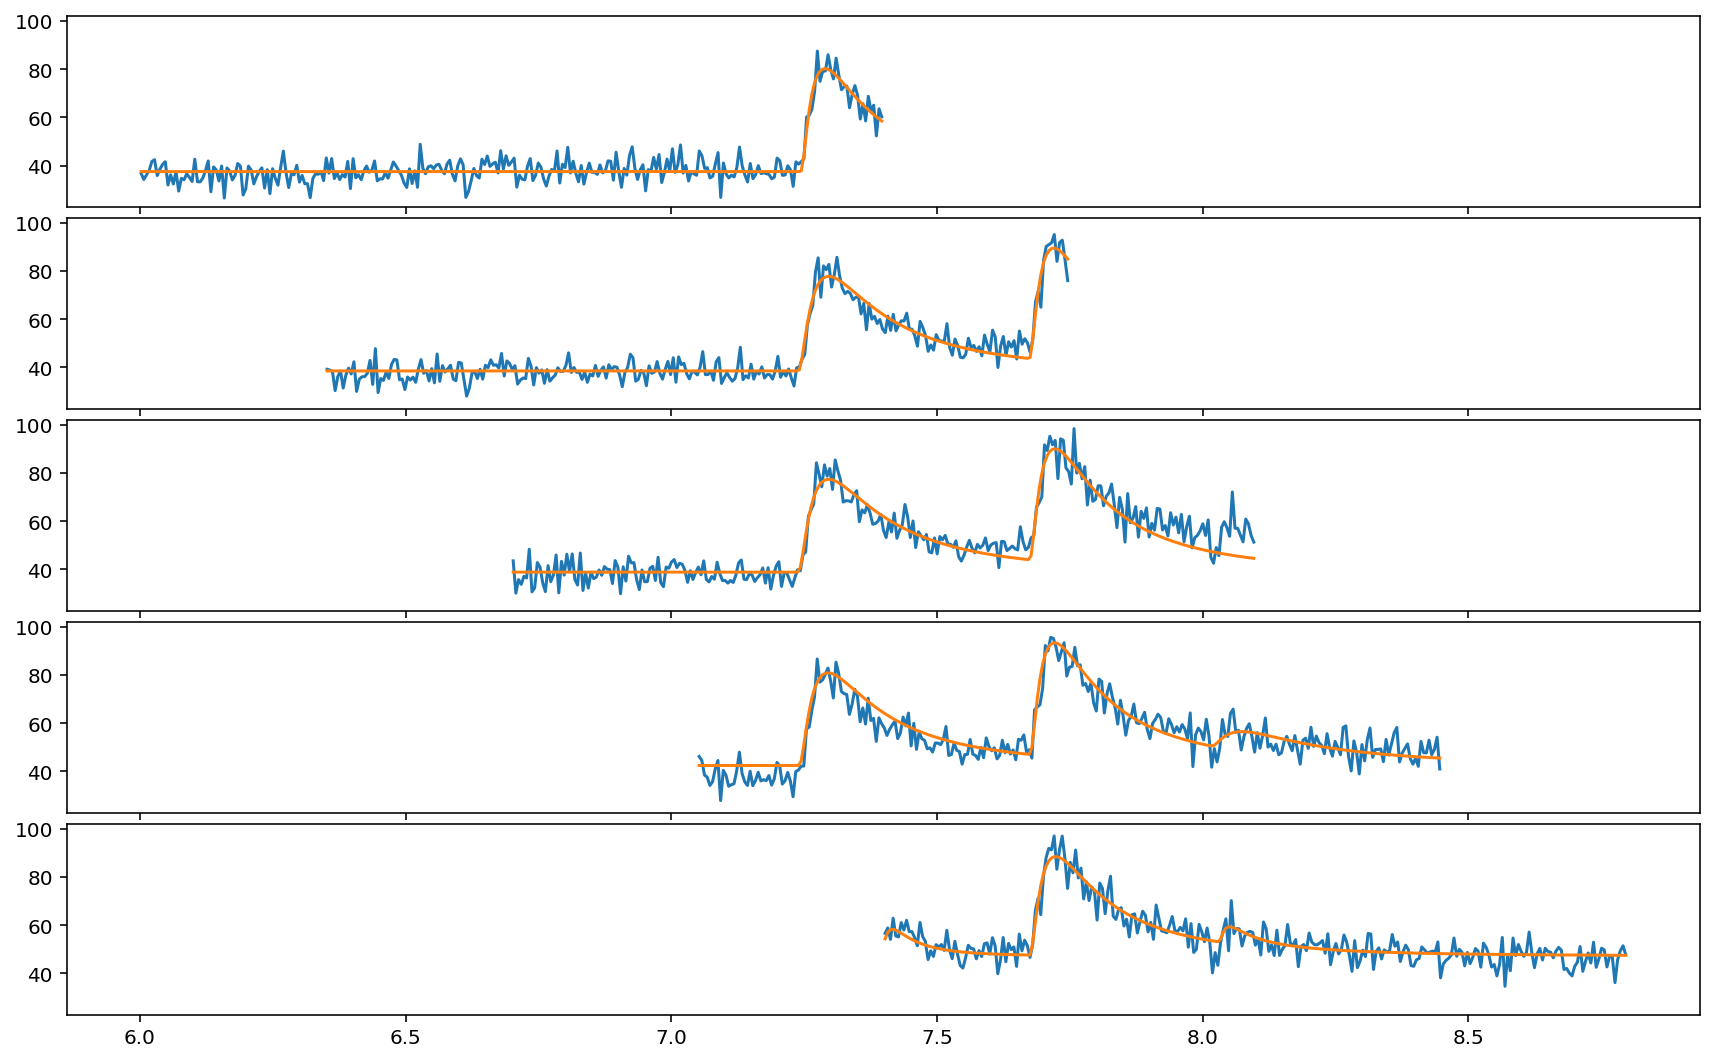

In [504]:
%%time
DeltaT = 1.4
t0s = np.arange(6,8,DeltaT/4)[:-1]
avgWindow = 20
fig, axs = plt.subplots(len(t0s),1,figsize=(12,1.5*len(t0s)), sharex=True,sharey=True)
PS = OrderedDict()
for t0,ax in zip(t0s,axs):
    timeWindow = (t0,t0+DeltaT)
    print(timeWindow)
    t,x = getSmoothT(timeWindow,avgWindow), getSmoothPx(iShow,timeWindow,avgWindow)
#     PS[timeWindow] = Fit(t,x,ax=ax,nPeaks=10,verbose=False,showFailed=False)
    PS[timeWindow] = manyFit(t,x)
    ax.plot(t,x)
    ax.plot(t,multiFun(t,PS[timeWindow]))
    
fig.tight_layout(h_pad=0.001)
# fig.savefig("./tmp.png")
# plt.close(fig)

In [505]:
manyFit(t,x)

accepted because the fve difference was large enough: 121.574426 --> 22.804074 (0.812427)
accepted because the fve difference was large enough: 22.804074 --> 21.290939 (0.066354)
stopped because there was nothing else to find


[array([11.12866969, 48.31408088,  7.39368908,  0.06022309]),
 array([41.03590679, -0.74877087,  7.67371432,  0.13493658]),
 array([ 6.87862951, -0.39202497,  8.03006756,  0.06036125])]

In [53]:
# autocorr(x,[1,2,3,4],nsplits=4)

/Users/srdjan/anaconda2/envs/physio/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


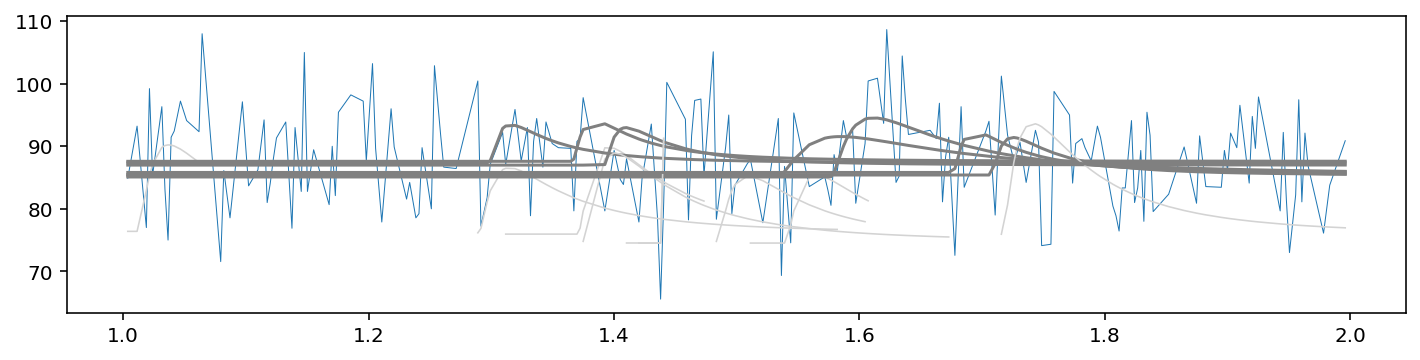

In [57]:
plt.figure(figsize=(12,6))
ax = plt.subplot(211)
iShow = 90
timeWindow = (1,2)
avgWindow = 10
t,x = getSmoothT(timeWindow,avgWindow), getSmoothPx(iShow,timeWindow,avgWindow)
# iSeed = 0
trainIdx = np.random.choice(np.arange(len(t)),replace=False,size=len(t)//2)
trainIdx.sort()
ps = Fit(t[trainIdx],x[trainIdx],ax=ax,nPeaks=10)

In [306]:
ps

[array([7.80391573e+00, 8.69969615e+01, 1.59904358e+00, 5.00000000e-02])]

In [318]:
ps

[array([6.73450469e+00, 8.71377217e+01, 1.60023746e+00, 5.00000000e-02])]

In [311]:
EvalModel([],t,x)/EvalModel(ps,t,x)>1.1

True

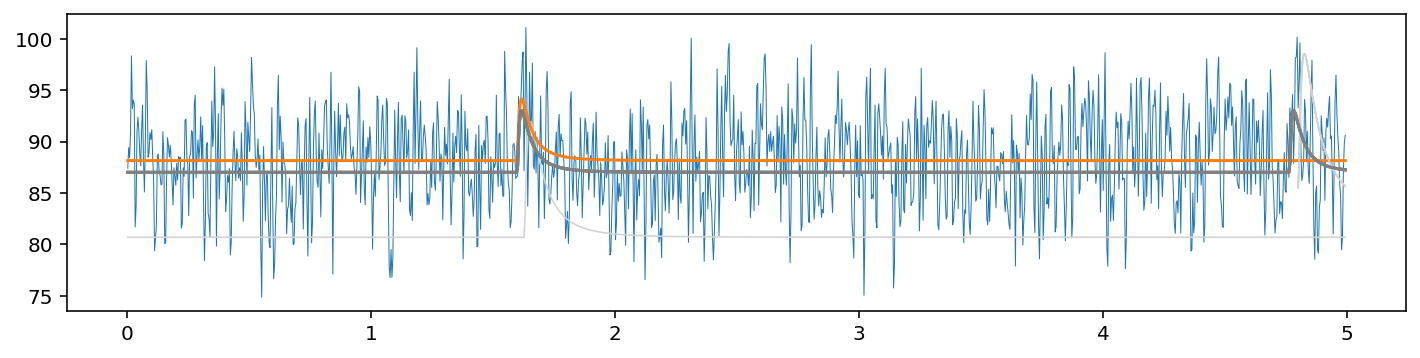

In [283]:
plt.figure(figsize=(12,6))
ax = plt.subplot(211)
iShow = 90
timeWindow = (0,5)
avgWindow = 30
t,x = getSmoothT(timeWindow,avgWindow), getSmoothPx(iShow,timeWindow,avgWindow)
iTrain
# ax.plot(t,x,lw=.3)
ps = Fit(t,x,ax=ax,nPeaks=5)

ValueError: x and y must have same first dimension, but have shapes (1979,) and (1,)

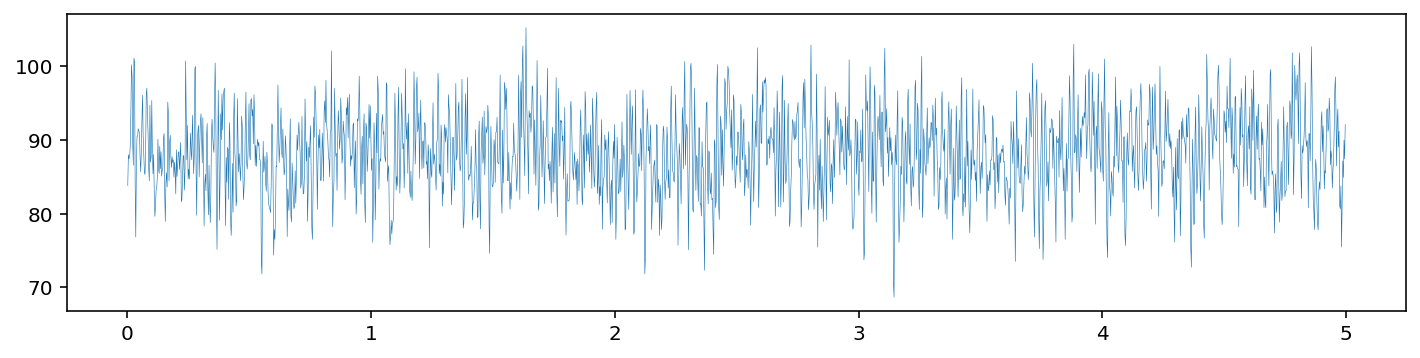

In [281]:
plt.figure(figsize=(12,6))
ax = plt.subplot(211)
ax.plot(t,x,lw=.3)
ax.plot(t,multiFun(t,ps))

In [272]:
ps

[array([6.65899299e+00, 8.79394084e+01, 1.59939848e+00, 5.00000000e-02]),
 array([6.00002766, 0.33335906, 2.41361518, 0.05934577]),
 array([ 6.        , -0.15954944,  2.57195818,  0.05      ]),
 array([6.0000025 , 0.19292992, 4.4930568 , 0.05000001]),
 array([ 7.17002305, -1.03442922,  4.76181041,  0.05      ])]

/Users/srdjan/anaconda2/envs/physio/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


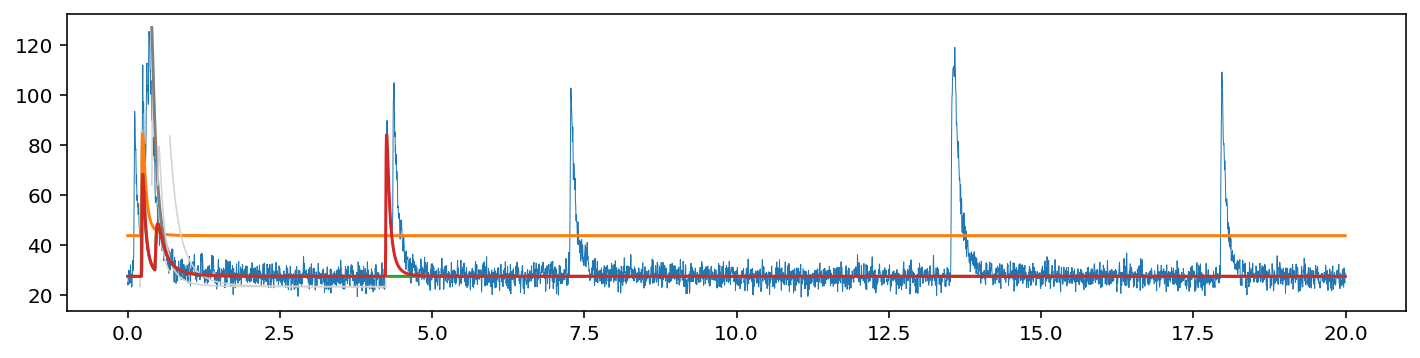

In [296]:
plt.figure(figsize=(12,6))
ax = plt.subplot(211)
iShow = 164
t,x = smoothTime, smoothAvgLine[:,iShow]
ps = Fit(t,x,ax=ax,nPeaks=10)

In [94]:
mostVariableLines[0]

272

0 (61.91862068965517, 22.212413793103448, 4.230949218988418, 0.07, 1.0)
1 (65.38720406668409, -4.025752966565477, 4.355916094303117, 0.07, 1.0)


ValueError: zero-size array to reduction operation maximum which has no identity

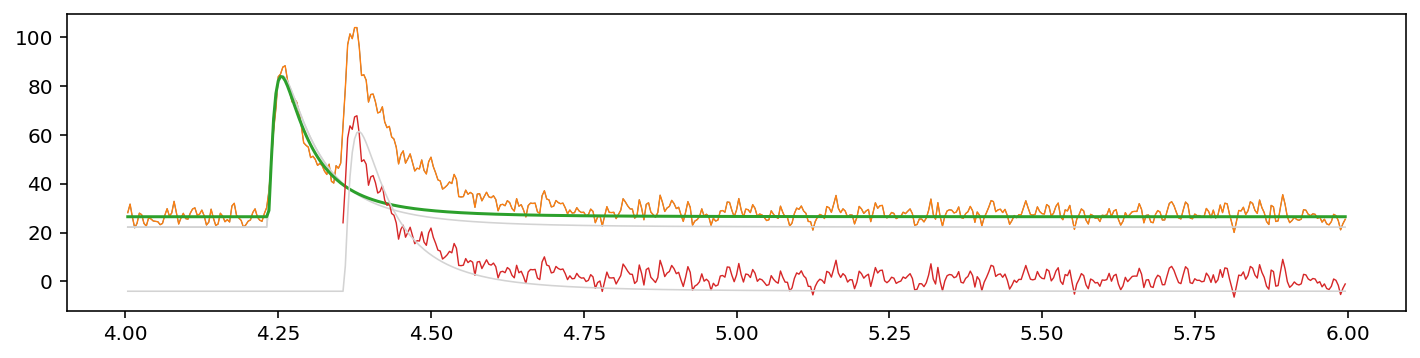

In [205]:
plt.figure(figsize=(12,6))
ax = plt.subplot(211)
iShow = 164
t,x = smoothTime, smoothAvgLine[:,iShow]
# plt.plot(t,x,"-",lw=.3);
ps = Fit(t,x,ax=ax,nPeaks=2)
# xfit = multiFun(t,ps)
# # plt.plot(t,xfit)
# ax = plt.subplot(212)
# # plt.plot(t,x-xfit)
# ps += fit(t,x-xfit,ax=ax)

In [157]:
ps

[array([57.38598041, 26.46048209,  4.23291732,  0.05978363]),
 array([60.37423368,  0.97743094,  4.34898699,  0.06739516])]

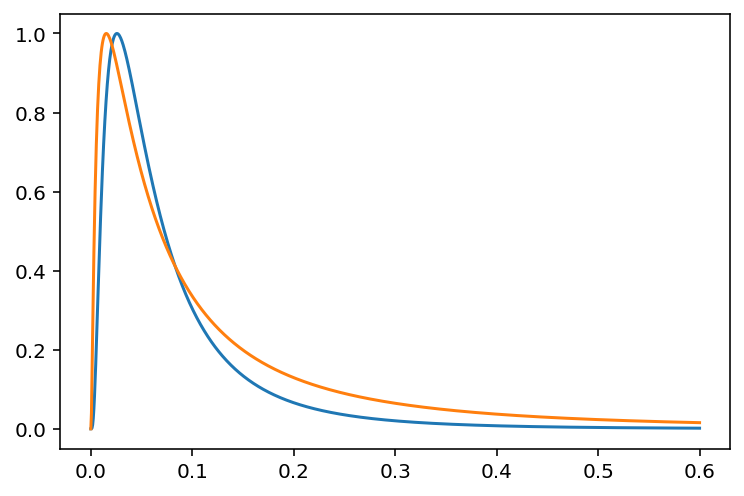

In [78]:
xr = np.linspace(0.0,.6,1000)
for p in ps:
    scale, s = p[-2:]
    yr = dst.lognorm.pdf(xr,s,scale=scale)
    plt.plot(xr,yr/yr.max())
# plt.yscale("log")

In [58]:
yfit = ps

[array([5.76956986e+01, 3.02030021e+00, 4.23071866e+00, 5.57679204e-02,
        8.79578236e-01]),
 array([65.77982969,  0.70152949,  4.35522923,  0.0770941 ,  1.27412577])]

47.25694444444445


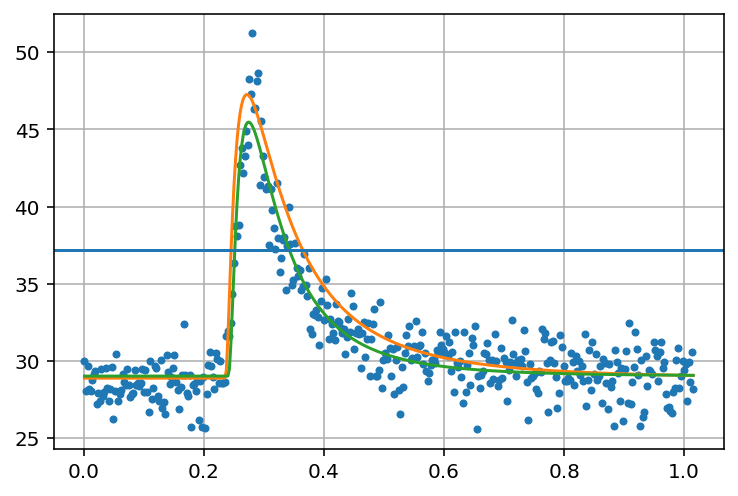

In [516]:
td = avgt[avgWindow][:n:10]#[::avgWindow]
xd = y              [:n:10]#[::avgWindow]
plt.plot(td,xd,".")
# pars = np.array([20,np.median(y),.235,.07,.7])
pars = guessPars(td,xd)
yd = myLogNorm(td,*pars)
plt.plot(td,yd)
p_opt,p_cov = curve_fit(myLogNorm,td,xd,p0=pars)
yd = myLogNorm(td,*p_opt)
plt.plot(td,yd)
# plt.xlim(.1,.5)
plt.axhline((p_opt[0]/2+offset))
plt.grid()

CPU times: user 943 ms, sys: 105 ms, total: 1.05 s
Wall time: 629 ms


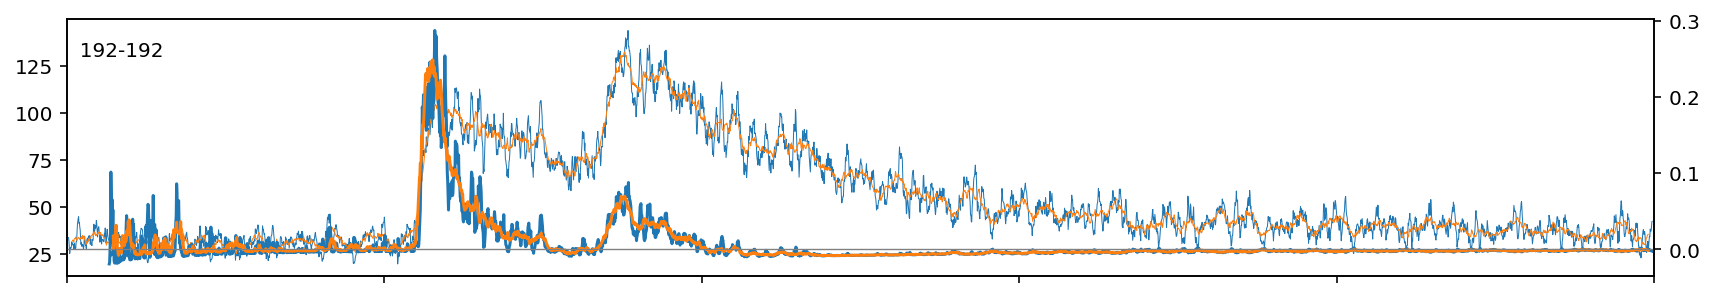

In [574]:
%%time
fig, axs = plt.subplots(len(RFs),1,figsize=(12,len(RFs)*2), sharex=True, sharey=False)
for ir in range(len(RFs)):
    ax = axs[ir]
    axr = ax.twinx()
    roi = RFs[ir]
    x = LineT[twIndices,roi].mean(axis=1)
    x = x
#     ax.plot(time[twIndices],x,lw=.2)
    ax.text(0,1,"\n  %i-%i"%(roi[0],roi[-1]),transform=ax.transAxes, va="top")
    for avgWindow in windows[1:3]:
        t = moving_average(time[twIndices],avgWindow-1)
        y = moving_average(x   [twIndices],avgWindow-1)
        ax.plot(t,y,lw=.5)
        cumStd = np.array([np.std(y[:i]) for i in range(len(y))])
        cumStd[:100] = np.nan
        ys = np.diff(cumStd)
        axr.plot(t[1:],ys)
        axr.axhline(0,color="grey",lw=.6)
    ax.set_xlim(timeWindow)
#     ax.axhline(0,color="grey",lw=.6)
    break
for ax in axs[ir+1:]:
    ax.remove()
fig.tight_layout()

In [577]:
from scipy import signal

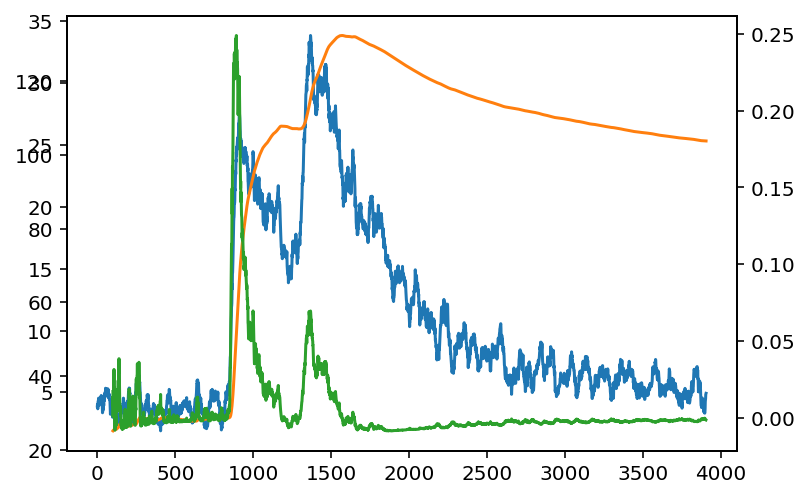

In [594]:
plt.plot(y)
plt.twinx();plt.plot([])
cumStd = np.array([np.std(y[:i]) for i in range(len(y))])
cumStd[:100] = np.nan
plt.plot(cumStd)
plt.twinx();plt.plot([]);plt.plot([])
plt.plot(np.diff(cumStd))
# plt.yscale("log")

In [564]:
cumStd

[nan,
 0.0,
 0.2586206896551726,
 0.30454347814923655,
 0.4570591773038479,
 0.5370461333498426,
 0.667062902461926,
 0.7118183987463415,
 0.7546427838867167,
 0.8702970465605784,
 0.8403045707958255,
 0.8015521346913721,
 0.7847037708123178,
 0.7597791233113554,
 0.7449059371827198,
 0.7571424120017248,
 0.7789181907361585,
 0.7689794018210757,
 0.747411282766975,
 0.7297992472915826,
 0.7238484643118088,
 0.7214352567102585,
 0.7078065166103817,
 0.718924556729426,
 0.7619969605031847,
 0.7467739575256529,
 0.8058205260683226,
 0.8243515614326886,
 0.8341312195375599,
 0.8212940928377789,
 0.8286144633788365,
 0.8202245327514531,
 0.8277650837127112,
 0.8584090002762161,
 0.9894240769002038,
 1.0819043950583578,
 1.0852904666558791,
 1.1256943393479593,
 1.1600038963279033,
 1.1590537348904038,
 1.1444740703662903,
 1.1304311074417992,
 1.122930928563722,
 1.1130667492375879,
 1.1078345068833002,
 1.1008707657124477,
 1.0914408866174188,
 1.109936184119376,
 1.1295385890696181,
 1.14

In [ ]:
def guessOffset(x):

In [777]:
def guessPars(t,x):
    offset = np.percentile(x,30)
    imax = np.argmax(x)
    xmaxAvg = x[max(imax-3,0):min(len(x),imax+3)].mean()
#     print(xmaxAvg)
    Ampl = xmaxAvg-offset
    loc = t[np.where(x[:imax]<offset)[0][-1]]
#     xhalfWidth = x.copy()
    scale = .1
    s = 1
    return Ampl,offset,loc,scale,s

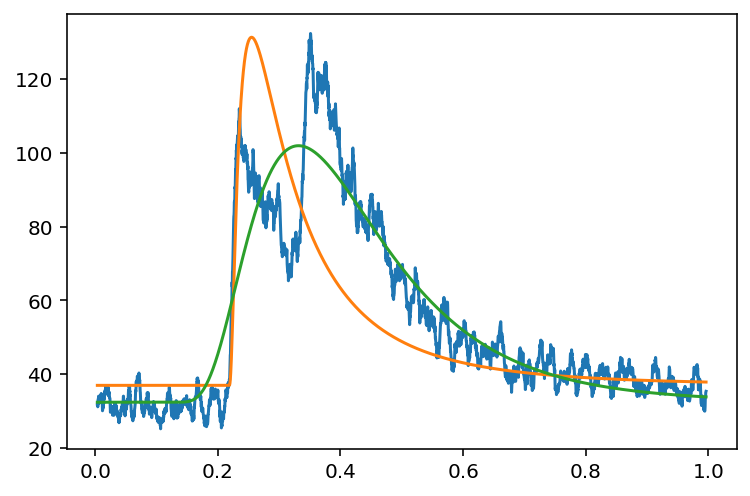

In [559]:
plt.plot(t,y)
p0 = guessPars(t,y)
plt.plot(t,myLogNorm(t,*p0))
p = curve_fit(myLogNorm,t,y,p0=p0)[0]
plt.plot(t,myLogNorm(t,*p))

In [560]:
Nsig = 2

In [ ]:
def multiSignal(t,ps):
    

# Smooth and threshold

In [809]:
timeWindow = 0,20
avgWindow = 10
pxAvg = 1

twIndices = slice(*(np.where(time>=tl)[0][0] for tl in timeWindow))
smoothTime = moving_average(time[twIndices],avgWindow-1)[::avgWindow//2]
smoothLine = np.array([moving_average(line,avgWindow-1)[::avgWindow//2] for line in LineT[twIndices].T]).T
smoothAvgLine = smoothLine.reshape(len(smoothLine),LineT.shape[1]//pxAvg,pxAvg).mean(axis=-1)
offsets = np.percentile(smoothAvgLine,5,axis=0)
offsetM = np.array([offsets]*len(smoothAvgLine))
fig = plt.figure(figsize=(6,6),dpi = 150)
ax = plt.subplot(111)
X = smoothAvgLine-offsetM
ax.imshow(X, cmap="hot",vmin=-2)
# ax.imshow(np.log10(X), cmap="Greys_r",vmin=-2)
# plt.xticks([])
plt.xlabel("space")
plt.ylabel("time[s]")
nt = 21
tt = np.linspace(timeWindow[0],timeWindow[1],nt)
plt.yticks(np.linspace(0,len(X)-.5,nt),["%.2g"%el for el in tt])
plt.xticks([])
ax.set_aspect("auto")
# ax.grid(linewidth = .2)
ax.xaxis.set_label_position("top")
path = f"./data/{filename.split('.')[0]}/{Name}.png"
fig.tight_layout()
fig.savefig(path)
plt.close(fig)

In [731]:
# %%time
# for t0 in np.arange(0,19.,.05):
#     timeWindow = np.array([t0,t0+1])
#     avgWindow = 10
#     pxAvg = 2

#     twIndices = slice(*(np.where(time>=tl)[0][0] for tl in timeWindow))
#     smoothTime = moving_average(time[twIndices],avgWindow-1)[::avgWindow//2]
#     smoothLine = np.array([moving_average(line,avgWindow-1)[::avgWindow//2] for line in LineT[twIndices].T]).T

#     smoothAvgLine = smoothLine.reshape(len(smoothLine),LineT.shape[1]//pxAvg,pxAvg).mean(axis=-1)

#     offsets = np.percentile(smoothAvgLine,1,axis=0)

#     offsetM = np.array([offsets]*len(smoothAvgLine))

#     fig = plt.figure(figsize=(5,3),dpi = 300)
#     ax = plt.subplot(111)
#     X = smoothAvgLine-offsetM
#     ax.imshow(X.T,extent=(timeWindow[0],timeWindow[1],0,1))
#     # plt.xticks([])
#     plt.ylabel("space")
#     plt.xlabel("time[s]")
#     # tt = np.linspace(int(timeWindow[0]),int(timeWindow[1]),6)
#     # # tt = np.linspace(timeWindow[0],timeWindow[1],11)
#     # # tt = tt[(tt*10).astype(int)%2==0]
#     # dtt = -(timeWindow[0]-int(timeWindow[0]))*len(X)
#     # poss = dtt+np.linspace(0,len(X),len(tt))
#     # tt = ["%.2g"%el for el in tt]
#     # if poss[0]<0:
#     #     poss = poss[1:]
#     #     tt=tt[1:]
#     # plt.xticks(poss,tt)
#     plt.yticks([])
#     ax.set_aspect("auto")
#     ax.grid(linewidth = .2)
#     path = f"./data/{filename.split('.')[0]}/{Name}/"
#     path += "%05.2f-%05.2f.png"%tuple(timeWindow)
#     fig.tight_layout()
#     fig.savefig(path)
#     plt.close(fig)

In [735]:
(smoothAvgLine==smoothLine).all()

True

# Time profiles

In [815]:
t0 = 4
avgWindow = 30
pxAvg = 1

timeWindow = np.array([t0,t0+1])
twIndices = slice(*(np.where(time>=tl)[0][0] for tl in timeWindow))
smoothTime = moving_average(time[twIndices],avgWindow-1)[::avgWindow//2]
smoothLine = np.array([moving_average(line,avgWindow-1)[::avgWindow//2] for line in LineT[twIndices].T]).T
smoothAvgLine = smoothLine.reshape(len(smoothLine),LineT.shape[1]//pxAvg,pxAvg).mean(axis=-1)
offsets = np.percentile(smoothAvgLine,5,axis=0)
offsetM = np.array([offsets]*len(smoothAvgLine))
smoothAvgLine = smoothAvgLine - offsetM

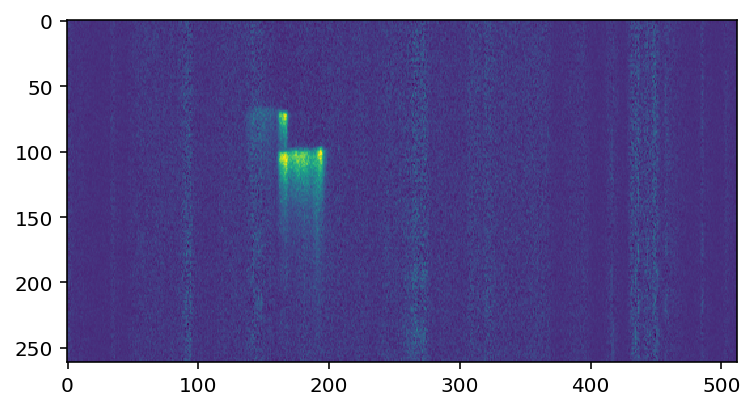

In [816]:
plt.imshow(smoothAvgLine)

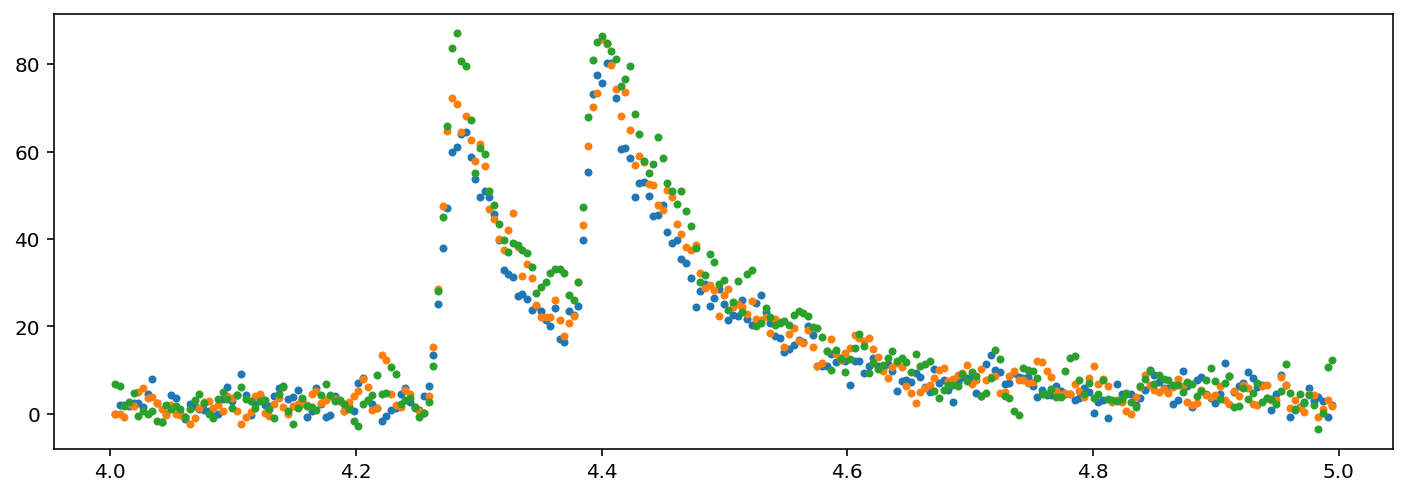

In [817]:
plt.figure(figsize=(12,4))
plt.plot(smoothTime, smoothAvgLine[:,164:167:],".-",ls="none");

In [1028]:
def guessBaseline(x):
    offset = np.percentile(x,2)
    xstd = x[x<=offset].std()
    return offset,xstd

In [1029]:
t,y = smoothTime,smoothAvgLine.T[164]

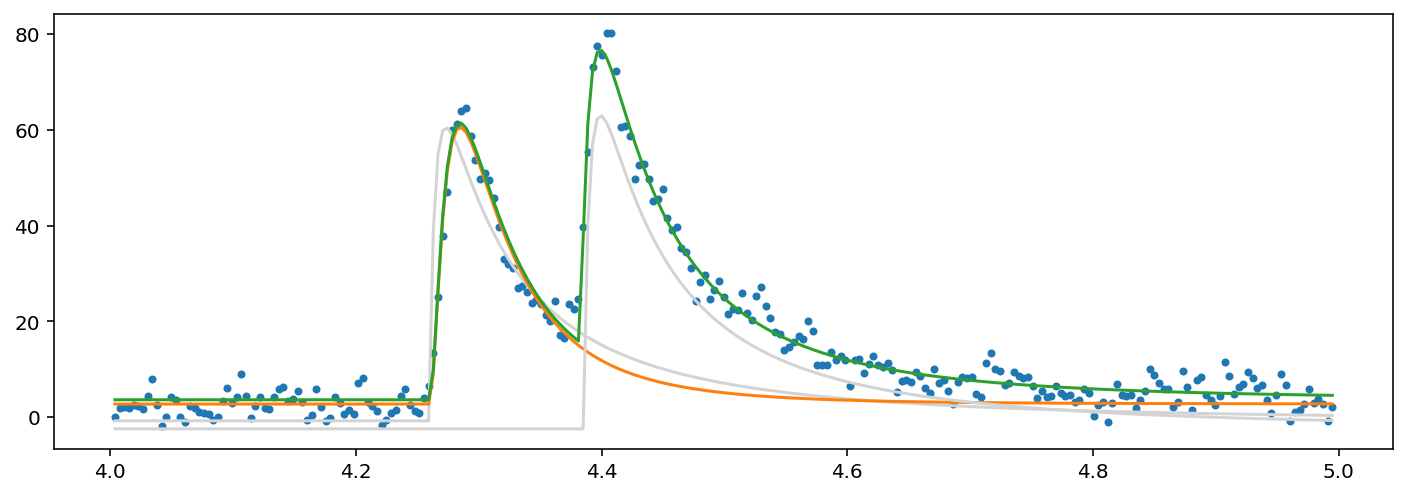

In [1030]:
plt.figure(figsize=(12,4))
plt.plot(t,y,".")
# x0,xe = guessBaseline(y)
# plt.fill_between(timeWindow,[x0]*2,[x0+15*xe]*2, alpha = .3)
iBegin = 0
ps = []
for i in range(3):
    y0 = np.sum([myLogNorm(t,*p) for p in ps], axis=0)
    tr,yr = t[iBegin:],(y-y0)[iBegin:]
    p0 = guessPars(tr,yr)
    if not p0:
        break
    plt.plot(t,myLogNorm(t,*p0),"lightgrey")
    iStop = np.where(yr-myLogNorm(tr,*p0)>20)[0][0] + iBegin
    p = curve_fit(myLogNorm,tr[:iStop],yr[:iStop],p0=p0)[0]
    plt.plot(t,y0+myLogNorm(t,*p))
    ps += [p]
    iBegin = iStop

In [1176]:
def guessPars(t,x):
    x0 = np.percentile(x,1)
    crit = x>x0+20
    if not np.any(crit):
        return False
    iloc = np.where(crit)[0][0]-2
    if iloc<1:iloc=1
    x0 = np.mean(x[:iloc])
    loc = t[iloc]
    imax = iloc+np.argmax(x[iloc:min(len(x),iloc+10)])
    xmaxAvg = x[max(imax-2,0):min(len(x),imax+3)].mean()
    if xmaxAvg<np.percentile(x,30):
        return False
    Ampl = xmaxAvg-x0
    scale = .08
    s = 1.3
    return Ampl,x0,loc,scale,s

In [1177]:
# def guessBaseline(x):
#     offset = np.percentile(x,5)
#     xstd = x[x<=offset].std()
#     return offset,xstd

def fit(t,y,ax=None,nPeaks=30):
    if ax:
        ax.plot(t,y,".")
    iBegin = 0
    score = np.sum((y-y.mean())**2)
    ps = []
    for ip in range(nPeaks):
        if iBegin>len(y)-10:
            break
        y0 = np.sum([myLogNorm(t,*p) for p in ps], axis=0)
        tr,yr = t[iBegin:],(y-y0)[iBegin:]
        p0 = guessPars(tr,yr)
        if not p0: break
#         p0 = p0[:-1]
        if ax: ax.plot(t,myLogNorm(t,*p0),"lightgrey",lw=.6)
        crit = yr-myLogNorm(tr,*p0)>20
        if not np.any(crit): 
            iStop = len(y)
        else:
            iStop = np.where(crit)[0][0] + iBegin
        try:
            t0 = p0[2]
            p = curve_fit(myLogNorm,tr[:iStop],yr[:iStop],p0=p0,
                          bounds=np.array([
                              (6,np.inf),
                              (-np.inf,np.inf),
                              (t0-.05,t0+.05),
                              (.05,.14),
                              (0.8,2),
                          ])[:len(p0)].T
                          
                         )[0]
        except:
            iBegin += 10
            continue
        ps += [p]
        iBegin = iStop+1
        y1 = np.sum([myLogNorm(t,*p) for p in ps], axis=0)
        newScore = np.sum((y-y1)**2)
        dScore = newScore-score
        if dScore>-30:
            ps = ps[:-1]
            if ax: ax.plot(t,y0+myLogNorm(t,*p),color="grey")
            continue
        score=newScore
        DScores
        if ax: ax.plot(t,y0+myLogNorm(t,*p))
            
    return ps
#     return pd.DataFrame(ps, columns=["Amplitude","offset","time","scale","s"])

-32465.86865462635
-68838.33268623978


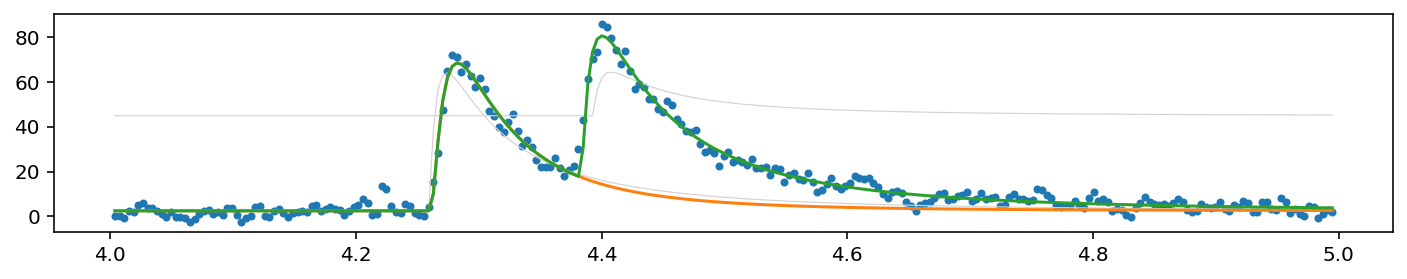

-48880.00026576615
-73813.96915394004


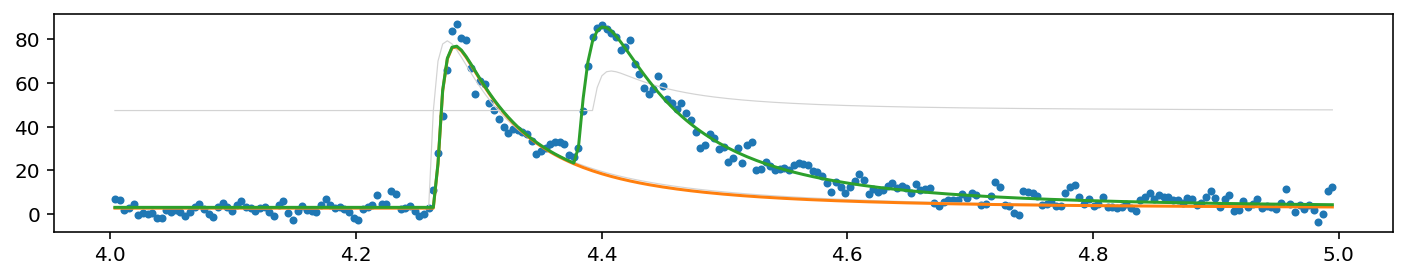

-1864.4045857784272


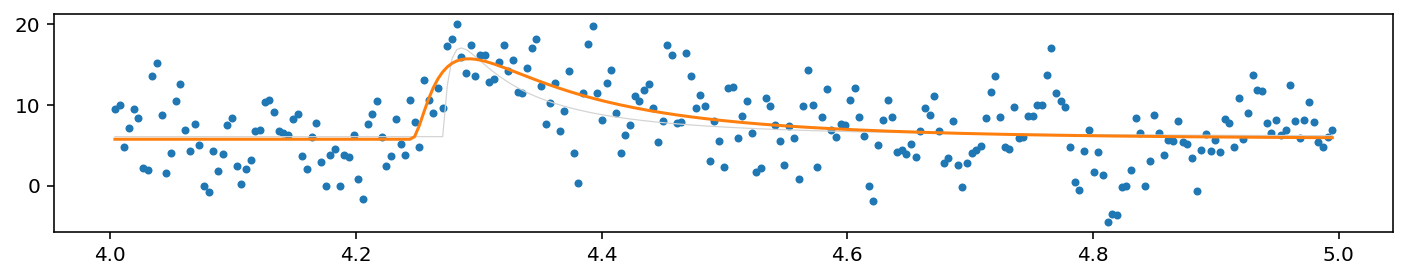

-1896.0979671142431


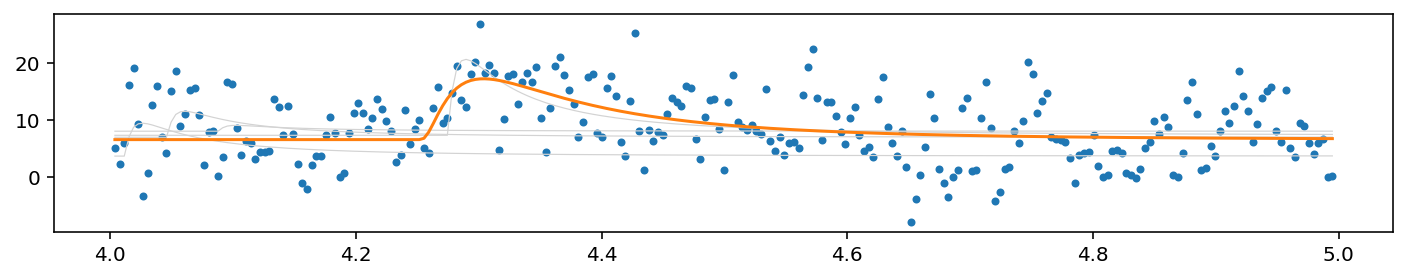

-58.703060529875074
-2163.3912673399464


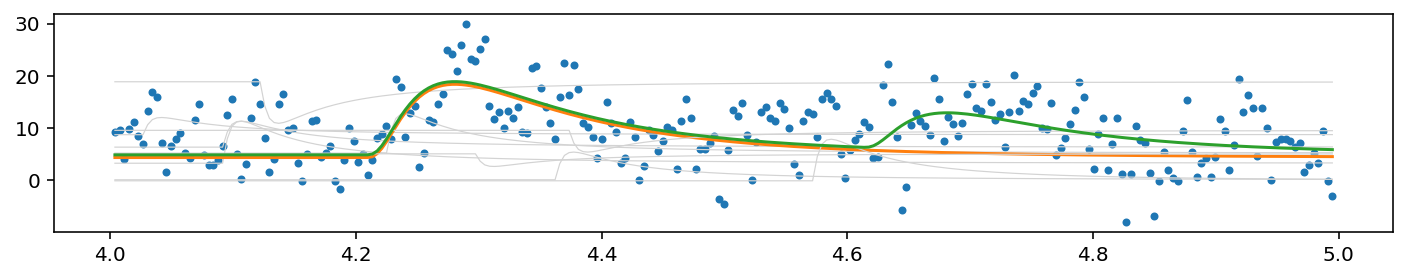

-1890.349504172963


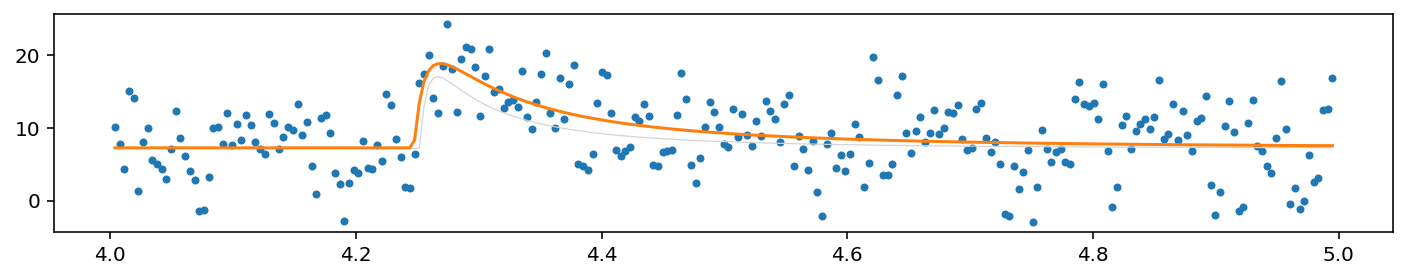

-1560.941976940413


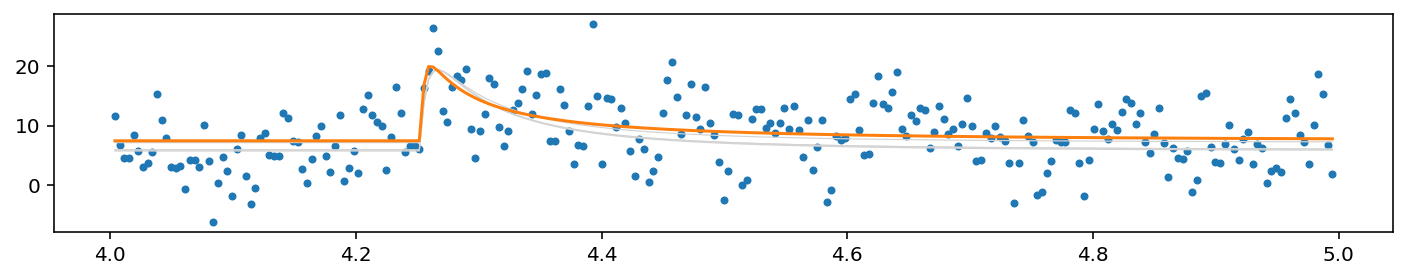

CPU times: user 28.7 s, sys: 966 ms, total: 29.7 s
Wall time: 7.85 s


In [1178]:
%%time
Spikes = []
# for px in range(165,167):
for px in list(range(165,167))+list(range(140,145)):
    plt.figure(figsize=(12,2))
    ax = plt.subplot(111)
    t,y = smoothTime,smoothAvgLine.T[px]
    ps = fit(t,y,ax = ax)
#     ax.plot(t,y,"o", mfc="none")
#     ax.plot(t,np.sum([myLogNorm(t,*p) for p in ps], axis=0))
    Spikes += [(px,)+tuple(p) for p in ps]
    plt.show()
#     break

In [1179]:
pd.DataFrame(Spikes,columns=["px","Amplitude","offset","time","scale","s"][:len(Spikes[0])])

px  Amplitude    offset      time     scale         s
0  165  65.929481  2.546410  4.260054  0.059519  0.984830
1  165  66.251148 -0.064372  4.382892  0.085592  1.236403
2  166  73.740340  2.781731  4.264492  0.069785  1.211351
3  166  67.165482  0.342540  4.378393  0.076237  1.065804
4  140   9.959266  5.730656  4.244064  0.124612  0.980614
5  141  10.704111  6.588876  4.251274  0.123223  0.923747
6  142  13.997659  4.373098  4.206605  0.140000  0.800000
7  142   7.112882  0.512042  4.610853  0.138392  0.800000
8  143  11.558023  7.242603  4.246405  0.120693  1.302341
9  144  12.434118  7.469380  4.253465  0.140000  1.731127

In [1181]:
%%time
Spikes = []
for px in range(LineT.shape[1]):
    t,y = smoothTime,smoothAvgLine.T[px]
    ps = fit(t,y,ax = False)
    Spikes += [(px,)+tuple(p) for p in ps]

-271.7398749754402
-221.16541885957758
-22.520158926602562
-279.04053945456144
-1864.4045857784272
-1896.0979671142431
-58.703060529875074
-2163.3912673399464
-1890.349504172963
-1560.941976940413
-1720.4068897832913
-1561.717472627729
-3453.3239392339938
-2669.2669209040105
-3246.7603259234634
-4182.787478660921
-3538.3416071356623
-3424.3950612158055
-3403.596477904384
-1960.3496403616978
-2950.194115249059
-2074.153631109663
-3697.906431908502
-10176.902756687034
-23122.176597933023
-30670.489394136057
-47004.2742763223
-20953.969903937534
-61646.67619017772
-32465.86865462635
-68838.33268623978
-48880.00026576615
-73813.96915394004
-36465.26780120483
-73641.09139201476
-6029.149049429485
-54961.98001311573
3299.8507297141987
-37518.55231094597
-37757.717710385026
-41221.72059259711
-45050.32580032089
-52050.89461006427
-57760.22547054019
-54304.217142542206
-52006.493932392485
-47127.61693205928
-52603.531979849045
-52757.95922004825
-1352.7954804121837
-52112.119884878775
-43235.2

In [1182]:
Spikes = pd.DataFrame(Spikes,columns=["px","Amplitude","offset","time","scale","s"])

In [1186]:
Spikes.Amplitude/Spikes.Amplitude.max()

0     0.117212
1     0.073070
2     0.110239
3     0.120910
4     0.129953
        ...   
88    0.099843
89    0.118245
90    0.072843
91    0.081413
92    0.072843
Name: Amplitude, Length: 93, dtype: float64

In [1189]:
clrs = plt.cm.viridis(Spikes.Amplitude/Spikes.Amplitude.max())

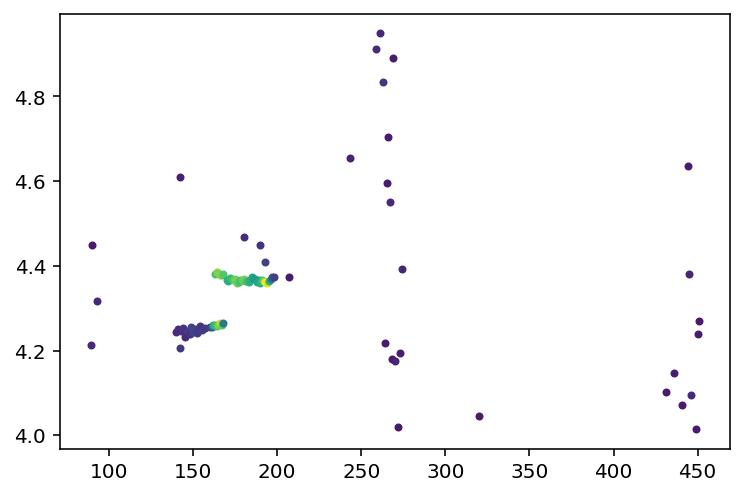

In [1190]:
for i, row in Spikes.iterrows():
    plt.plot(row.px,row.time,".",c=clrs[i])

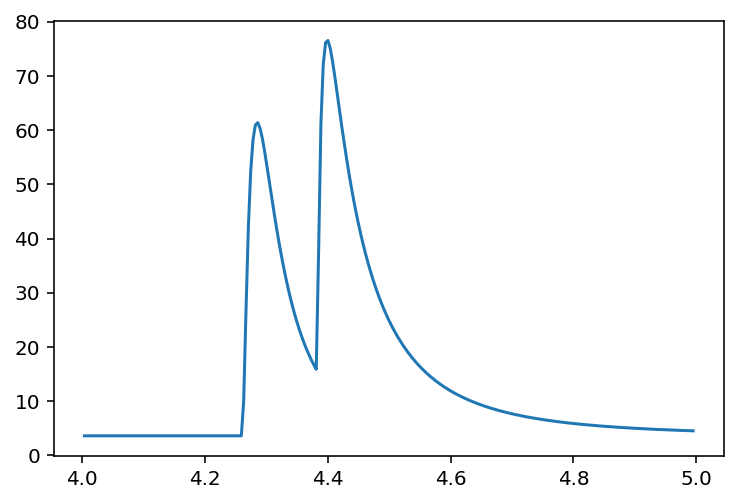

In [882]:
plt.plot(t,np.sum([myLogNorm(t,*p) for p in ps.values], axis=0))

# Time profiles again

In [1215]:
t0 = 0
avgWindow = 30
pxAvg = 1

timeWindow = np.array([t0,t0+1])
twIndices = slice(*(np.where(time>=tl)[0][0] for tl in timeWindow))
smoothTime = moving_average(time[twIndices],avgWindow-1)[::avgWindow//2]
smoothLine = np.array([moving_average(line,avgWindow-1)[::avgWindow//2] for line in LineT[twIndices].T]).T
smoothAvgLine = smoothLine.reshape(len(smoothLine),LineT.shape[1]//pxAvg,pxAvg).mean(axis=-1)
offsets = np.percentile(smoothAvgLine,5,axis=0)
offsetM = np.array([offsets]*len(smoothAvgLine))
smoothAvgLine = smoothAvgLine - offsetM

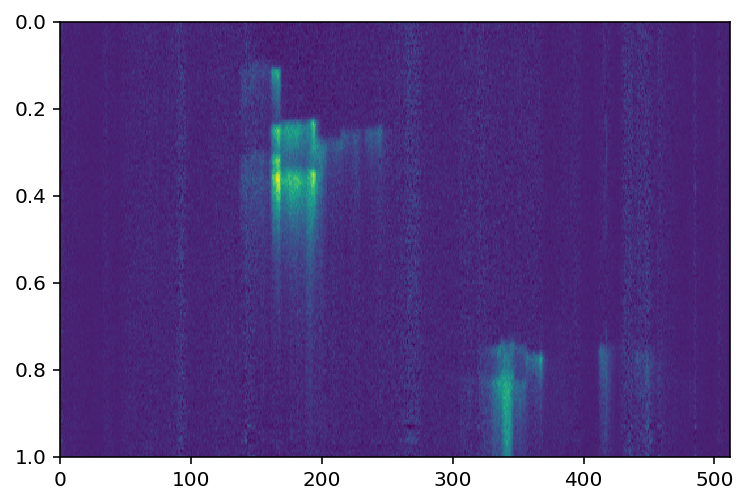

In [1216]:
plt.imshow(smoothAvgLine,extent=(0,LineT.shape[1],timeWindow[1],timeWindow[0]))
plt.gca().set_aspect("auto")

In [1217]:
# %%time
# for px in range(165,167):
# # for px in list(range(165,167))+list(range(140,145)):
#     plt.figure(figsize=(12,2))
#     ax = plt.subplot(111)
#     t,y = smoothTime,smoothAvgLine.T[px]
#     ps = fit(t,y,ax = ax)
#     plt.show()

In [1211]:
%%time
Spikes = []
for px in range(LineT.shape[1]):
    t,y = smoothTime,smoothAvgLine.T[px]
    ps = fit(t,y,ax = False)
    Spikes += [(px,)+tuple(p) for p in ps]

-47.757411521304675
-129.48080012021637
-369.994018463246
-315.5352178008761
-153.57061148476623
-1673.9633253809043
-3310.2662843289636
-2189.4910975554612
-1659.4914280951743
2980.4010096675484
-458.0243358872285
-267.03051785335083
-268.3049779873181
-957.6569345479711
-775.044513192559
-1735.521964523381
497.9213464171298
-1499.6899420148075
-2244.1287278750024
-303.88569237331103
-7466.775738213745
-1193.3744121717264
3040.412355515773
-624.3507348274779
-3319.5588835023154


/Users/srdjan/anaconda2/envs/physio/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


-1644.1645369890794
-1789.7235026689414
-1393.6189950595544
2888.4364950890395
-1093.838440998119
872.7489065299633
-1234.1399658588944
-1550.409157848544
-2825.052448772014
-2324.531863781838
-2325.6433996374344
14794.367227372495
-16819.107441064094
37833.418300491656
-55006.943186854216
-19980.889808297645
59756.58099878946
-76500.91677275933
-33574.47053218904
62454.25841092237
-96456.64032320004
-31448.69351278658
57982.38605305285
-120560.33989623704
-49224.38457167013
92968.56403723906
-142725.7902670991
-58231.69915044123
88923.32107927586
-118091.07500414399
-82017.07367847723
58616.515844725625
-86507.63938331518
-38504.45522170587
-51447.0411319535
-37727.27729270367
-41707.29509473074
-43335.22039123608
-48894.90359650927
-39879.34584635838
-59230.55470544397
-37290.373345246044
-64726.17868681359
-44385.36092069779
-55467.733899434315
-56979.71450378525
-81184.6034212759
-48662.26120736674
-17576.11725056413
-99767.50453285001
-33092.75382425732
-83256.1770495516
-54562.35

In [1218]:
Spikes = pd.DataFrame(Spikes,columns=["px","Amplitude","offset","time","scale","s"])

In [1222]:
clrs = plt.cm.hot(Spikes.Amplitude/Spikes.Amplitude.max())

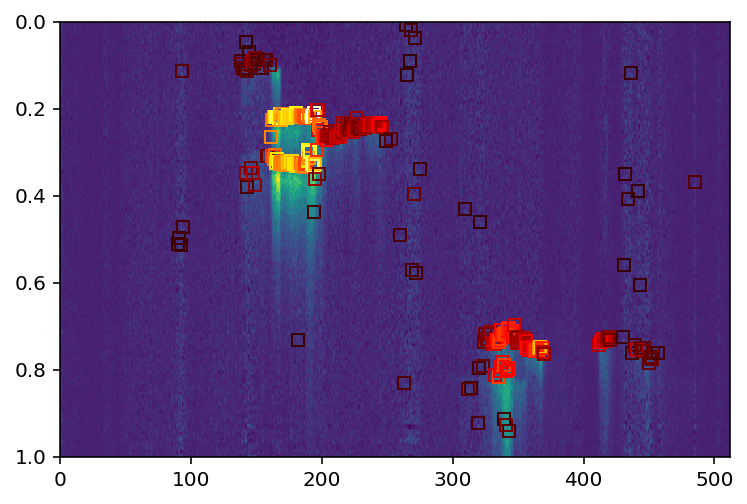

In [1223]:
plt.imshow(smoothAvgLine,extent=(0,LineT.shape[1],timeWindow[1],timeWindow[0]))
plt.gca().set_aspect("auto")
for i, row in Spikes.iterrows():
    plt.plot(row.px,row.time,"s",c=clrs[i], mfc="none")

In [1243]:
Binarized = np.ones_like(smoothAvgLine)*np.nan

In [1244]:
for _,row in Spikes.iterrows():
    it = np.argmin(np.abs(smoothTime-row.time))
    px = int(row.px)
    Binarized[it,px] = row.Amplitude

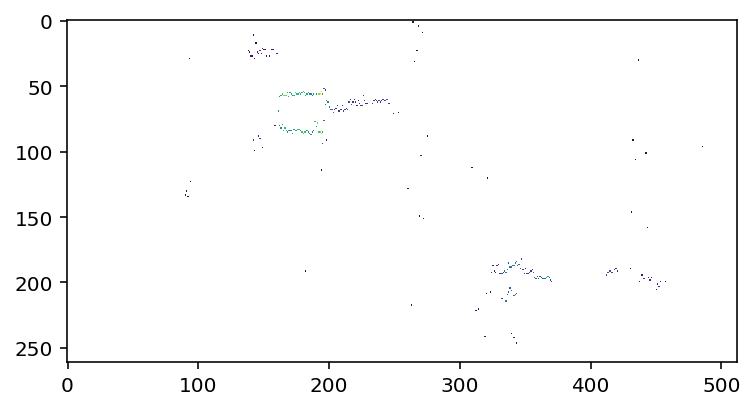

In [1245]:
plt.imshow(Binarized)

133

In [ ]:
Binarized

In [1301]:
mdf

Name     AcquisitionDate     X     Y     T  C  Z  nAverageLine_1  \
0    Image006 2019-08-27 09:44:57  1024  1024     1  1  1             128   
1    Image010 2019-08-27 09:49:28  1024  1024     1  1  1             128   
2    Image012 2019-08-27 09:50:10  1024  1024     1  1  1             128   
3   Series013 2019-08-27 09:50:40   512   512  7583  1  1               8   
4    Image017 2048-03-12 10:41:23  1024  1024     1  1  1            1024   
5    Image018 2019-08-27 11:04:23  1024  1024     1  1  1             128   
6   Series019 2019-08-27 11:05:13   512   512  2037  1  1               8   
7    Image021 2019-08-27 11:25:48  1024  1024     1  1  1             128   
8   Series022 2048-03-12 11:03:52  1024  1024     1  1  1             128   
9   Series023 2019-08-27 11:26:47   512   512   984  1  1               8   
10  Series027 2019-08-27 11:42:04   512   512   117  1  1               4   
11  Series029 2019-08-27 11:43:54   512  8192    10  1  1               4   
12  Series031 2019-08-27 11:45:27   512   512   515  1  1               8   
13   Image033 2019-08-27 11:50:31   512  8192     1  1  1               4   
14  Series034 2019-08-27 11:51:18   512  8000    10  1  1               4   
15  Series035 2019-08-27 11:51:58   512  8000    10  1  1               4   
16  Series036 2019-08-27 11:52:19   512  8000    10  1  1               4   
17  Series037 2019-08-27 11:52:40   512  8000    10  1  1               4   
18  Series038 2019-08-27 11:53:20   512   512   350  1  1               8   
19  Series039 2019-08-27 11:58:35   512  8000    10  1  1               4   
20  Series040 2019-08-27 11:58:57   512  8000    10  1  1               4   
21  Series041 2019-08-27 11:59:19   512  8000    10  1  1               4   
22  Series042 2019-08-27 11:59:56   512   512  1874  1  1               8   
23  Series043 2019-08-27 12:24:31   512  8000    10  1  1               4   
24  Series044 2019-08-27 12:24:52   512  8000    10  1  1               4   
25  Series045 2019-08-27 12:25:14   512  8000    10  1  1               4   
26   Image047 2019-08-27 12:29:13  1024  1024     1  1  1             128   
27  Series048 2019-08-27 12:30:18   512   512   543  1  1               8   
28  Series050 2019-08-27 12:35:37   512  8000    10  1  1               4   
29  Series051 2019-08-27 12:35:58   512  8000    10  1  1               4   
30  Series052 2019-08-27 12:36:21   512  8000    10  1  1               4   
31  Series053 2019-08-27 12:36:54   512   512    10  1  1               8   
32  Series054 2019-08-27 12:37:19   512  8000    10  1  1               8   
33  Series055 2019-08-27 12:38:03   512  8000    10  1  1               4   
34  Series056 2019-08-27 12:38:36   512   512   430  1  1               8   
35  Series058 2019-08-27 12:44:34   512   512     9  1  1               4   
36  Series059 2019-08-27 12:44:55   512  8000    10  1  1               4   
37  Series060 2019-08-27 12:45:17   512  8000    10  1  1               4   
38  Series061 2019-08-27 12:45:38   512  8000    10  1  1               4   
39  Series062 2019-08-27 12:46:09   512   512   351  1  1               8   
40  Series063 2019-08-27 12:51:09   512  8000    10  1  1               4   
41  Series064 2019-08-27 12:51:32   512  8000    10  1  1               4   
42  Series065 2019-08-27 12:51:54   512  8000    10  1  1               4   
43  Series066 2019-08-27 12:52:37   512   512   412  1  1               8   
44  Series067 2019-08-27 12:58:14   512  8000    10  1  1               4   
45  Series068 2019-08-27 12:58:37   512  8000    10  1  1               4   
46  Series069 2019-08-27 12:58:59   512  8000    10  1  1               4   
47  Series070 2019-08-27 12:59:38   512   512    38  1  1               8   
48  Series071 2019-08-27 13:00:44   512  8000    10  1  1               4   
49  Series072 2019-08-27 13:01:27   512   512  2044  1  1               8   
50  Series073 2019-08-27 13:28:04   512  8000    10  1  1               4   
51  S

# Loop

In [1248]:
%%time
avgWindow = 30
pxAvg = 1
AllSpikeDict = OrderedDict()
for t0 in np.arange(0,19.1,.25):
    timeWindow = np.array([t0,t0+1])
    twIndices = slice(*(np.where(time>=tl)[0][0] for tl in timeWindow))
    smoothTime = moving_average(time[twIndices],avgWindow-1)[::avgWindow//2]
    smoothLine = np.array([moving_average(line,avgWindow-1)[::avgWindow//2] for line in LineT[twIndices].T]).T
    smoothAvgLine = smoothLine.reshape(len(smoothLine),LineT.shape[1]//pxAvg,pxAvg).mean(axis=-1)
#     offsets = np.percentile(smoothAvgLine,5,axis=0)
#     offsetM = np.array([offsets]*len(smoothAvgLine))
#     smoothAvgLine = smoothAvgLine - offsetM
    
    Spikes = []
    for px in range(LineT.shape[1]):
        t,y = smoothTime,smoothAvgLine.T[px]
        ps = fit(t,y,ax = False)
        Spikes += [(px,)+tuple(p) for p in ps]

    Spikes = pd.DataFrame(Spikes,columns=["px","Amplitude","offset","time","scale","s"])
    AllSpikeDict[t0] = Spikes

/Users/srdjan/anaconda2/envs/physio/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


CPU times: user 4h 28min 55s, sys: 8min 29s, total: 4h 37min 25s
Wall time: 1h 11min 8s


In [1302]:
# path = f"./data/{filename.split('.')[0]}/{Name}.txt"
# np.savetxt(path,LineT,fmt="%i")

In [1264]:
iShow = 165

(0, 20)

/Users/srdjan/anaconda2/envs/physio/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/srdjan/anaconda2/envs/physio/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


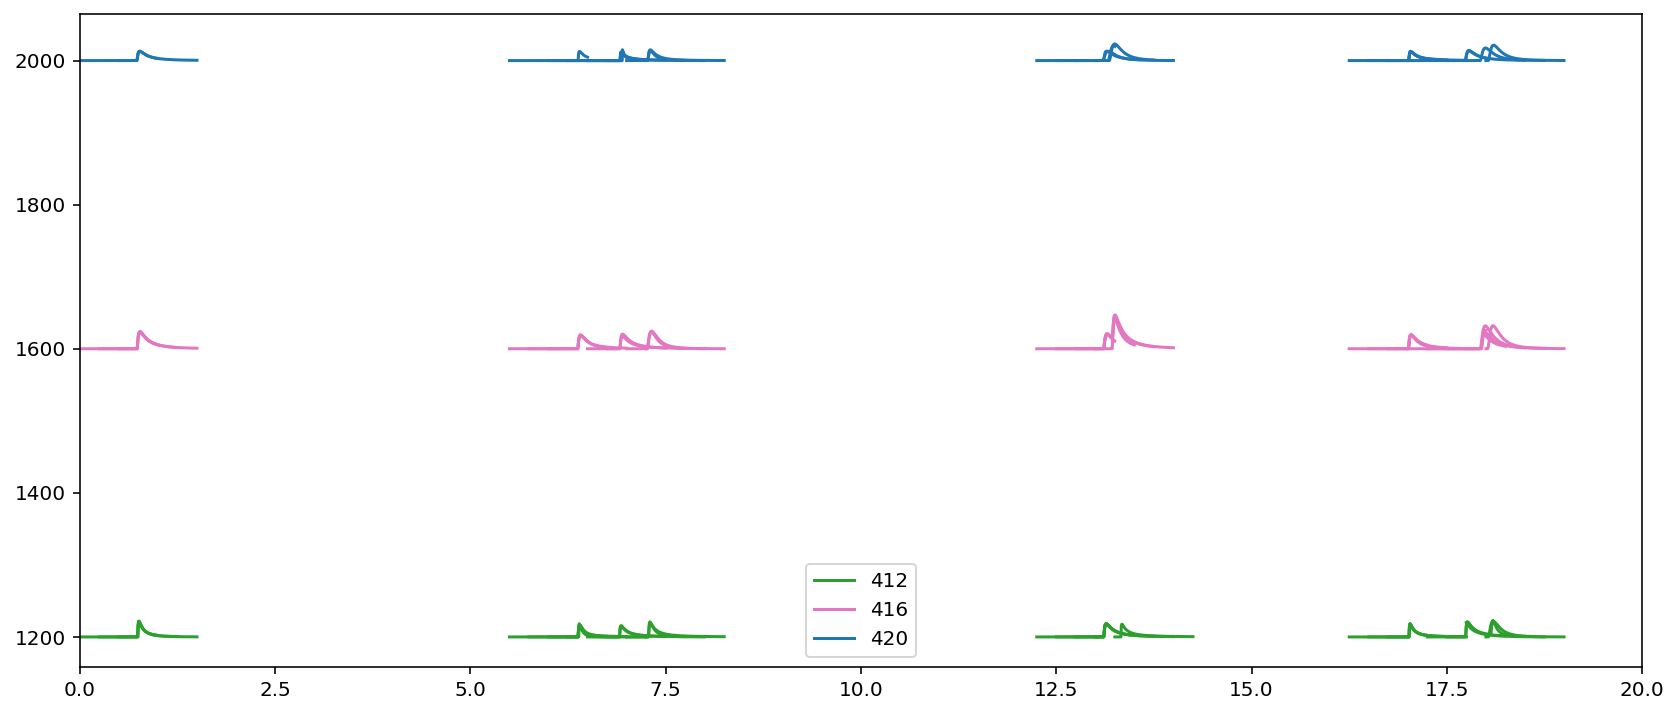

In [1368]:
traceShow = range(400,430,4)
doneTrace = []
# fig, axs = plt.subplots(len(traceShow),1,figsize=(14,2))
fig = plt.figure(figsize=(14,6))
ax = plt.subplot(111)
# for iShow,ax in zim(traceShow,)
for t0 in np.arange(0,20,.25):
    try: Spikes = AllSpikeDict[t0]
    except: break
    timeWindow = np.array([t0,t0+1])
    twIndices = slice(*(np.where(time>=tl)[0][0] for tl in timeWindow))
    t = time[twIndices]
    
    for iShow in traceShow:
    
        showSpikes = Spikes.query(f"px=={iShow}")
        ps = showSpikes.values[:,1:]
        if len(ps)>0:
            y = np.sum([myLogNorm(t,*p) for p in ps], axis=0)
            y0 = np.percentile(y,1)
            y0 += (-iShow+traceShow[0])*100
            if iShow in doneTrace:
                plt.plot(t,y-y0,c="C%i"%(iShow%10))
            else:
                plt.plot(t,y-y0,c="C%i"%(iShow%10),label=iShow)
                doneTrace += [iShow]
plt.legend()
plt.xlim(0,20)

In [1303]:
%%time
Offsets = OrderedDict()
avgWindow = 30
pxAvg = 1
for t0 in np.arange(0,19.1,.25):
    timeWindow = np.array([t0,t0+1])
    twIndices = slice(*(np.where(time>=tl)[0][0] for tl in timeWindow))
#     smoothTime = moving_average(time[twIndices],avgWindow-1)[::avgWindow//2]
    smoothLine = np.array([moving_average(line,avgWindow-1)[::avgWindow//2] for line in LineT[twIndices].T]).T
    smoothAvgLine = smoothLine.reshape(len(smoothLine),LineT.shape[1]//pxAvg,pxAvg).mean(axis=-1)
    offsets = np.percentile(smoothAvgLine,5,axis=0)
    Offsets[t0] = offsets

CPU times: user 2.78 s, sys: 168 ms, total: 2.95 s
Wall time: 3.41 s


In [1384]:
iShow = 411#346
smoothTime = moving_average(time          ,avgWindow-1)[::avgWindow//2]
smoothLine = moving_average(LineT.T[iShow],avgWindow-1)[::avgWindow//2]
t = smoothTime
allY = np.nan*np.ones((len(AllSpikeDict),len(smoothTime)))
for it,t0 in enumerate(np.arange(0,19.5,.25)):
    try: Spikes = AllSpikeDict[t0]
    except: break
    timeWindow = np.array([t0,t0+1])
    twIndices = slice(*(np.where(time>=tl)[0][0] for tl in timeWindow))
#     t = time[twIndices]
    offset = Offsets[t0][iShow]
    showSpikes = Spikes.query(f"px=={iShow}")
    ps = showSpikes.values[:,1:]
    if not len(ps): continue
    y = np.sum([myLogNorm(t,*p) for p in ps], axis=0)
    ff = y>y.min()+1
    y[~ff] = np.nan
    y += offset
    allY[it] = y
#     plt.plot(t[ff],y[ff])
# plt.legend()

In [1400]:
Name

'Series037'

/Users/srdjan/anaconda2/envs/physio/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: All-NaN slice encountered
  after removing the cwd from sys.path.


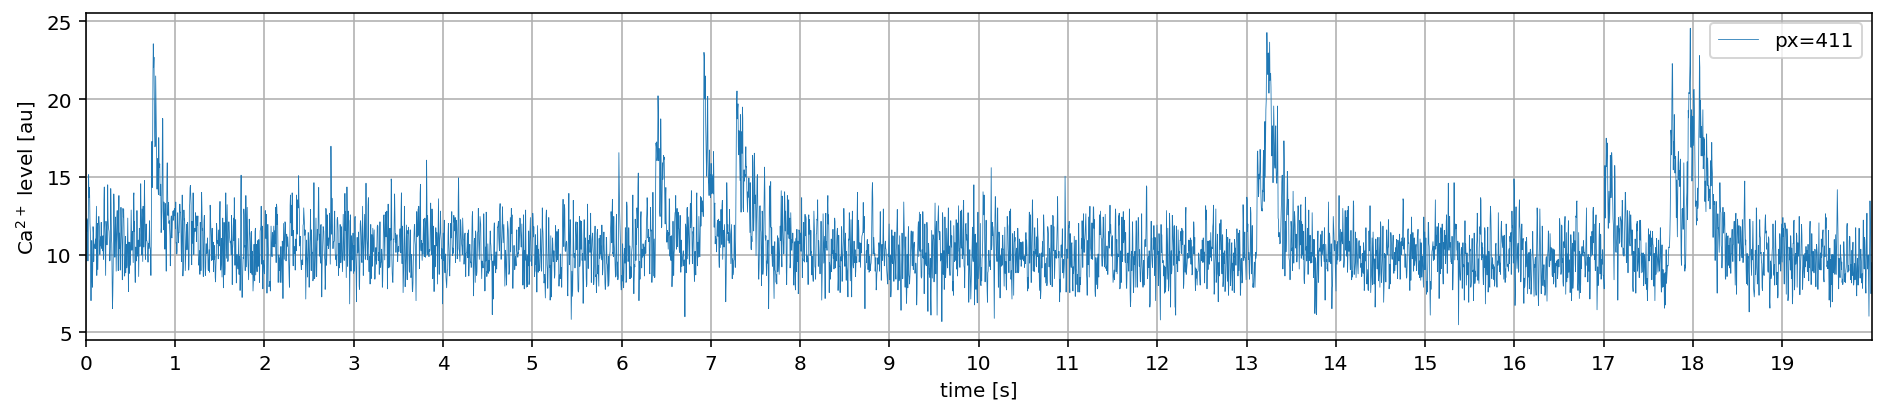

In [1385]:
fig = plt.figure(figsize=(16,3))
ax = plt.subplot(111)
ax.plot(smoothTime,smoothLine,"-",lw=.4,label="px=%i"%iShow)
ax.plot(smoothTime,np.nanmax(allY, axis=0))
plt.xlim(0,20)
plt.xticks(np.arange(0,20,1));
# plt.yticks([])
plt.grid()
plt.xlabel("time [s]")
plt.ylabel(r"Ca${}^{2+}$ level [au]")
plt.legend(loc=1)

In [1333]:
df = pd.concat(AllSpikeDict.values(),ignore_index=True)

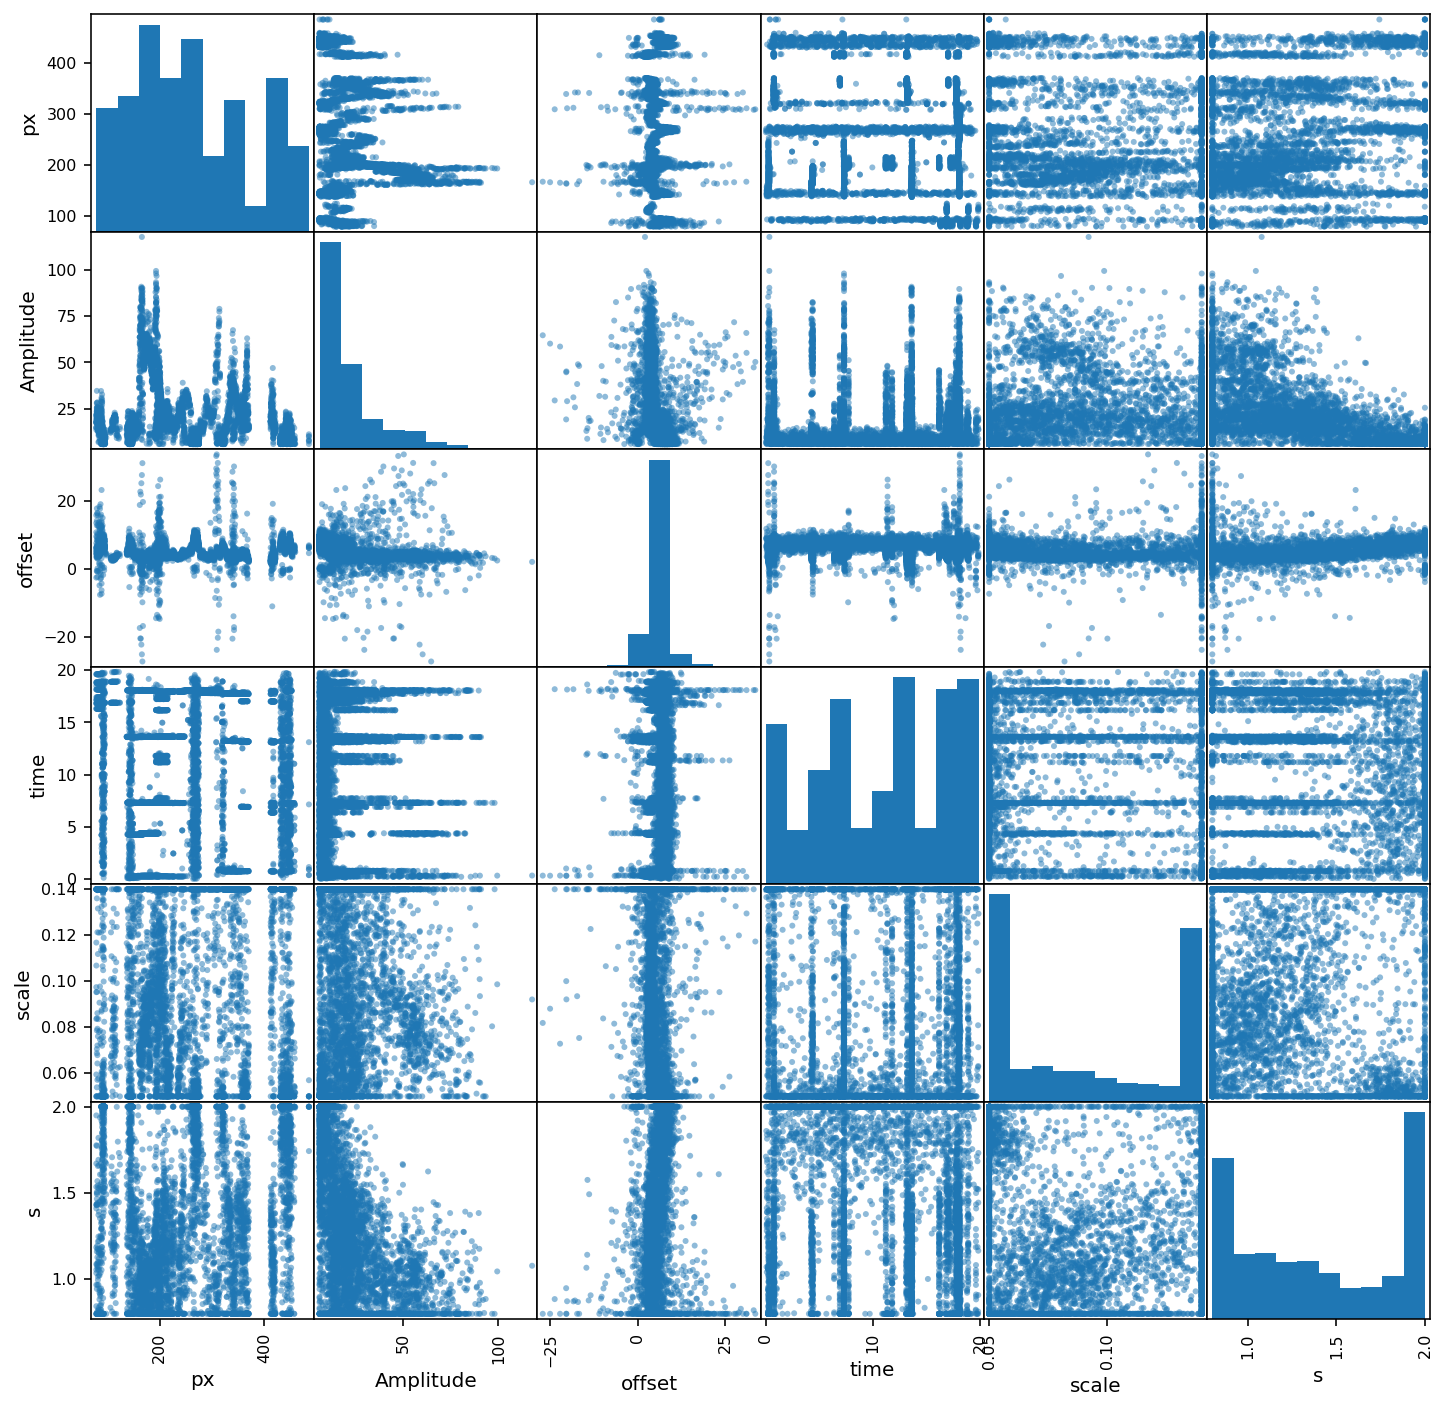

In [1386]:
pd.plotting.scatter_matrix(df, figsize=(12,12));

In [1387]:
smoothAvgLine.shape

(261, 512)

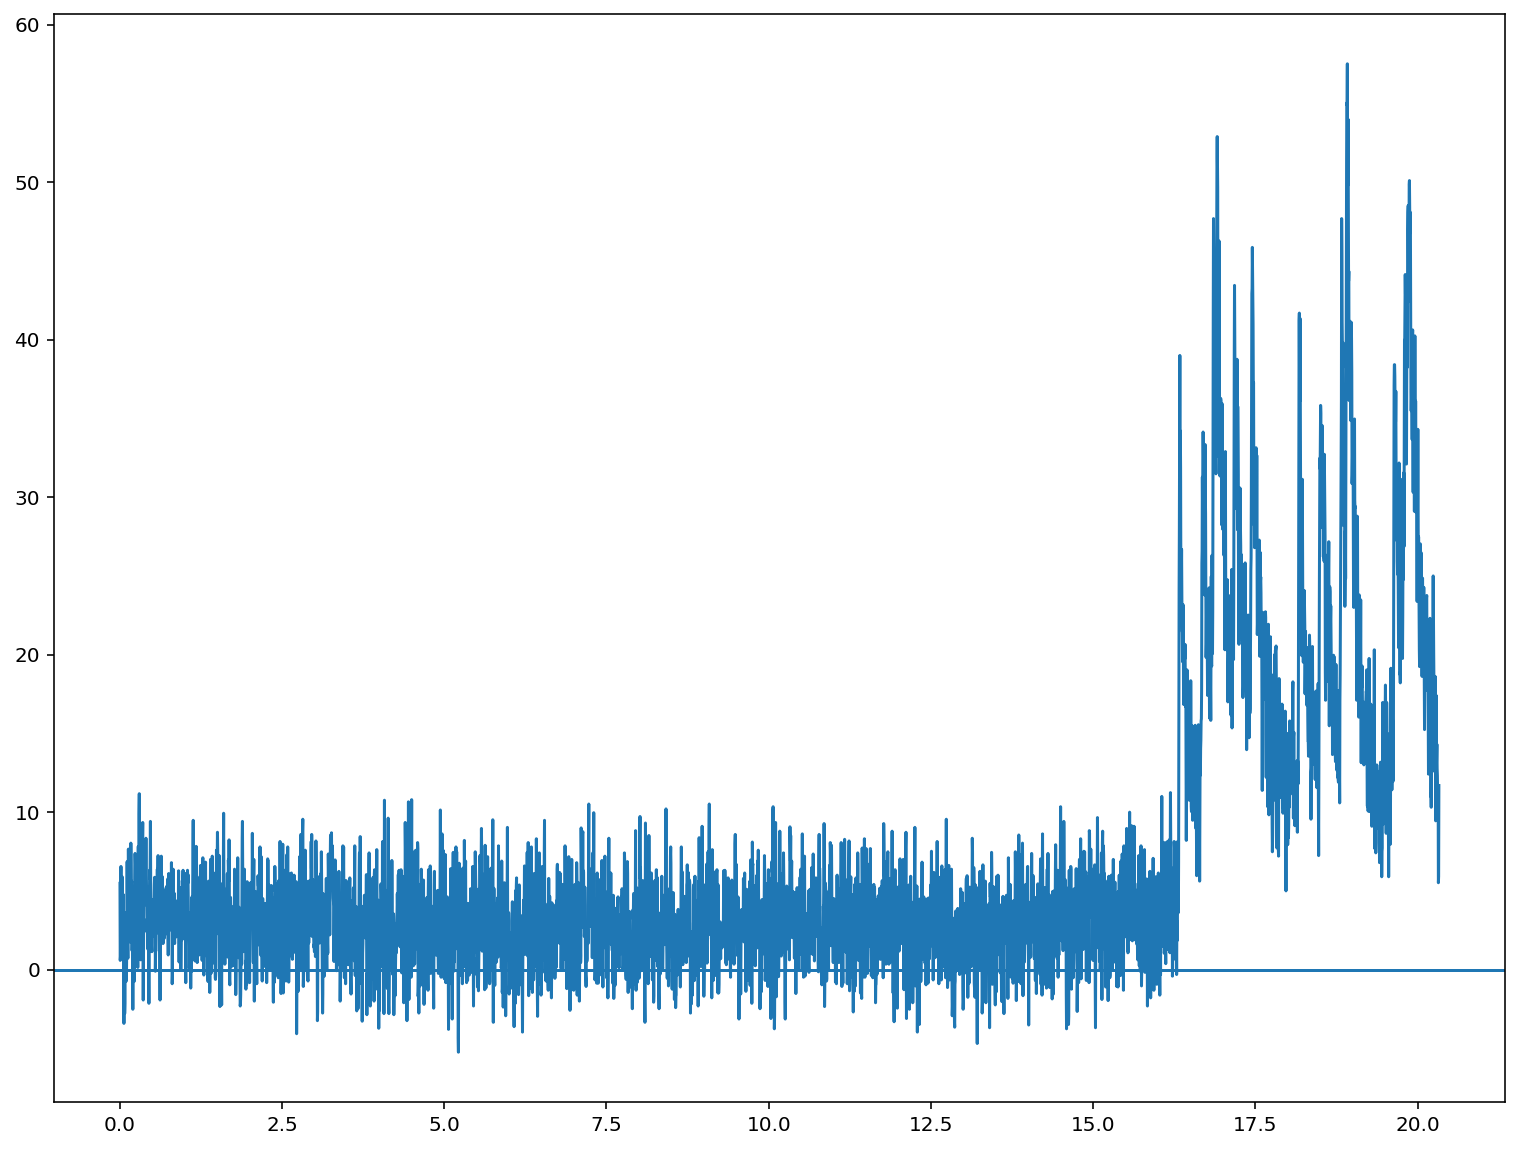

In [1397]:
plt.figure(figsize=(13,10))
for ipx,iShow in enumerate(np.argsort(np.var(smoothAvgLine,axis=0))[::-1][:10]):
    smoothLine = moving_average(LineT.T[iShow],avgWindow-1)[::avgWindow//2]
    y0 = np.percentile(smoothLine,10)
    smoothLine -= y0
    y0 = -ipx*50
    c = plt.plot(smoothTime,smoothLine+y0)[0].get_color()
    plt.axhline(y0,c=c)
    break

# Rest

In [ ]:
for i in range()

In [96]:
x = LineT[:,roi].mean(axis=1)

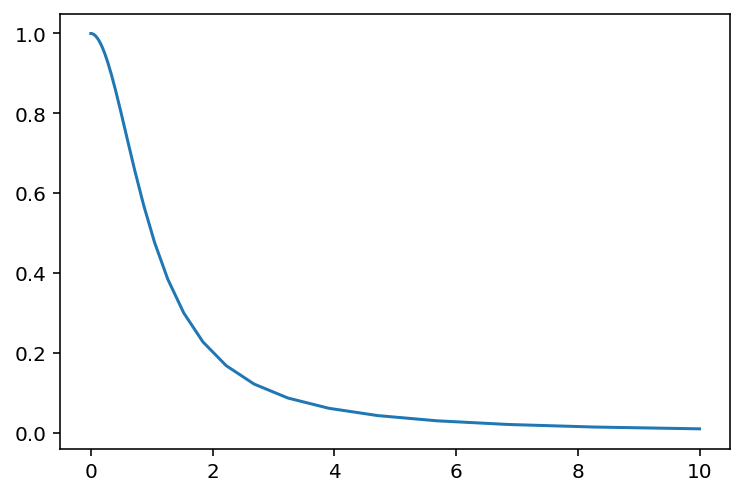

In [100]:
xr = np.logspace(-3,1)
plt.plot(xr,filterF(xr))

array([39.58495781-9.55502344e-15j, 55.43050898+2.78888024e-15j,
       74.32522943-4.16129353e-15j, ..., -7.42192607-1.37071622e-14j,
       11.5862063 +2.98835575e-15j, 15.46006807+3.61626450e-15j])

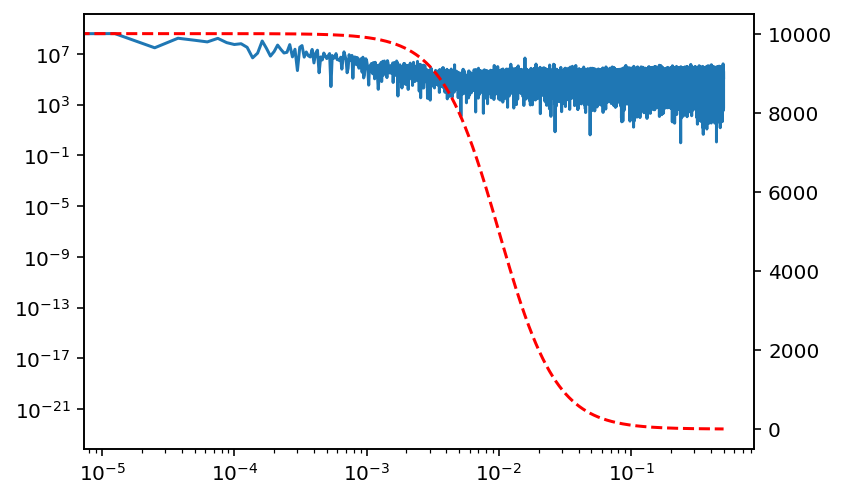

In [103]:
FFTFilter(x,th=.01,mode="low-pass",plotPwSOnly=True)

/Users/srdjan/anaconda2/envs/physio/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


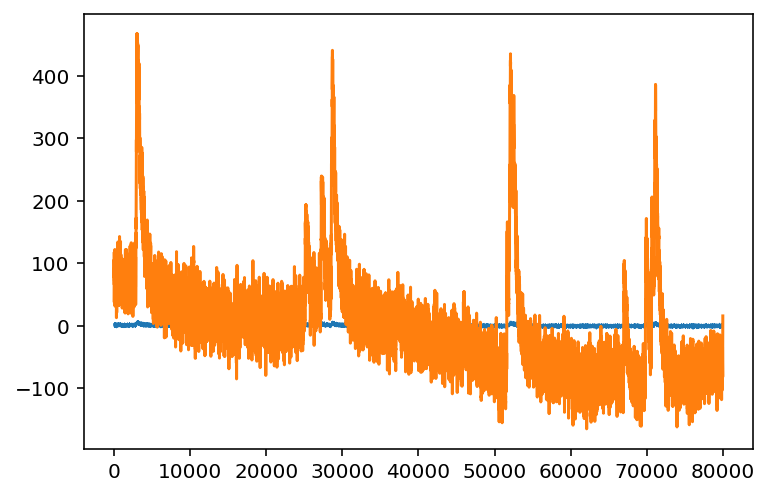

In [105]:
ax = plt.subplot(111)
ax.plot(x, lw=.4)
filx = FFTFilter(x,th=.01,mode="low-pass")
ax.plot(filx)

## See distributions and filter

In [45]:
Nsample = int(1e7)
pixelSample = np.random.choice(image.flatten(), Nsample)

In [46]:
x,y = np.array(tally(pixelSample)).T
xth =  80
yth = 1e5

<BarContainer object of 53 artists>

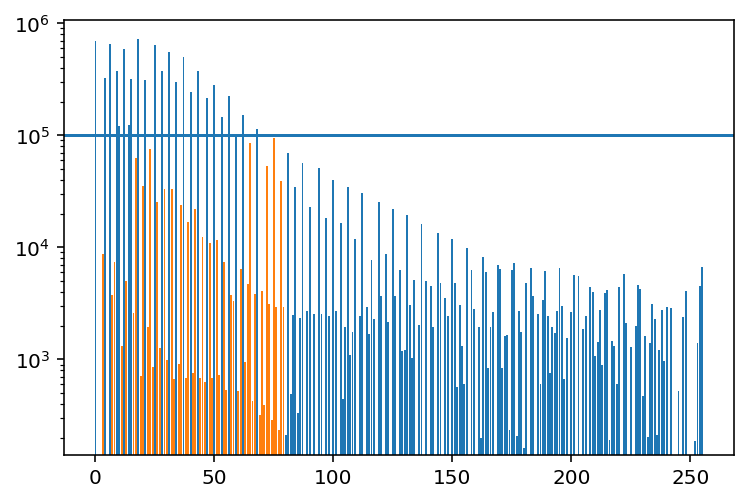

In [47]:
plt.bar(x,y)
plt.yscale("log")
plt.axhline(yth)
take = x[y<yth]
take = take[take<xth]

tmp = pixelSample
tmp = tmp[np.isin(tmp,take)]
x_noise,y_noise = np.array(tally(tmp)).T
plt.bar(x_noise,y_noise)

In [22]:
showTransposed = True

CPU times: user 606 ms, sys: 7.65 ms, total: 614 ms
Wall time: 612 ms


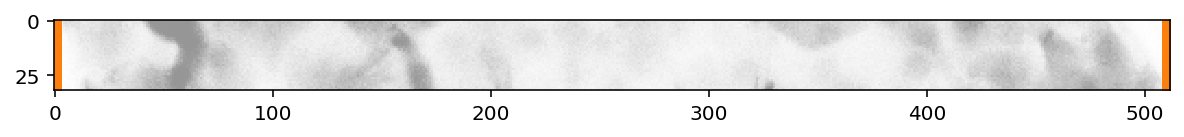

In [23]:
%%time
plt.figure(figsize=(10,4))
ims = image[::1000]
X = np.mean(ims,axis=0)
if not showTransposed: X = X.T
plt.imshow(X, cmap="Greys",vmax=2*256)
for t,x,y in zip(*np.where(np.isin(ims[:],take))):
    if showTransposed:
        x,y = y,x
    plt.plot(x,y,"C1s",
             alpha = .2
            )
#     if t>0:
#         break

In [24]:
Nsample = int(1e7)
pixelSampleRed = np.random.choice(image.T[1:-1].flatten(), Nsample)
xRed,yRed = np.array(tally(pixelSampleRed)).T

In [25]:
tmp = xRed[yRed>yth]
tmp = tmp[tmp<xth]
meanDiff = np.diff(tmp).mean()

del tmp

In [26]:
meanDiff

12.666666666666666

In [27]:
collectBulk = [xRed[0]]
for el in xRed[1:-1]:
    if np.abs(el-collectBulk[-1]-meanDiff)<1.5:
        collectBulk += [el]

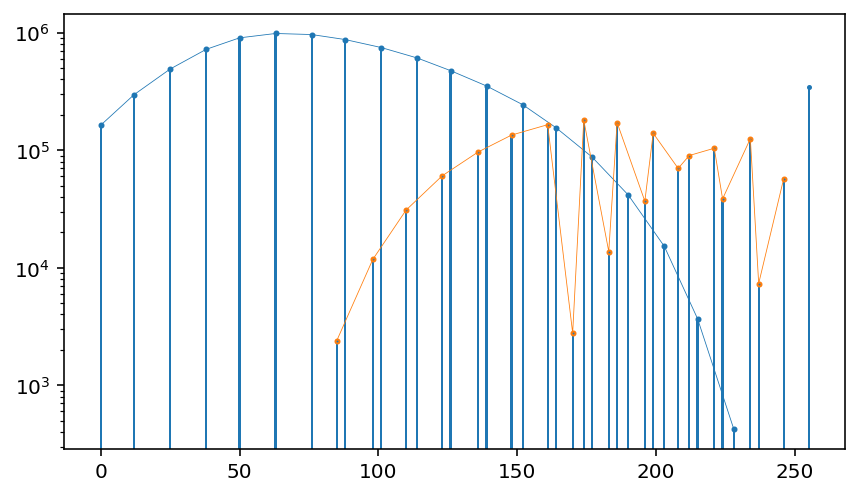

In [28]:
plt.figure(figsize=(7,4))
plt.bar(xRed,yRed,color="C0")
plt.plot(xRed,yRed,".-", ms=3, lw=0,color="C0")
plt.yscale("log")

fltr = np.isin(xRed, collectBulk)
for xf,yf in [
    (xRed[ fltr], yRed[ fltr]),
    (xRed[~fltr], yRed[~fltr]),
]:
    ff = xf!=xRed.max()
    xf = xf[ff]
    yf = yf[ff]
    plt.plot(xf,yf,".-", ms=4, lw=.4, mfc="none")

In [29]:
scale = np.diff(xRed[fltr]).mean()

In [30]:
np.diff(xf)

array([13, 12, 13, 13, 12, 13,  9,  4,  9,  3, 10,  3,  9,  4,  9,  3, 10,
        3,  9])

CPU times: user 807 ms, sys: 14.9 ms, total: 822 ms
Wall time: 820 ms


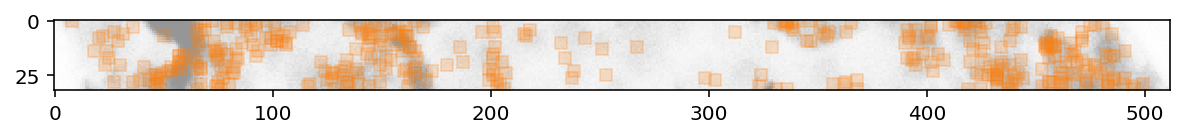

In [31]:
%%time
plt.figure(figsize=(10,4))
ims = image[::1000]
X = np.mean(ims,axis=0)
if not showTransposed: X = X.T
plt.imshow(X, cmap="Greys",vmax=2*256)
for t,x,y in list(zip(*np.where(np.isin(ims[:],xf))))[::100]:
    if showTransposed:
        x,y = y,x
    plt.plot(x,y,"C1s",
             alpha = .2
            )
#     if t>0:
#         break

In [32]:
# ## See features

# pd.options.display.max_rows = 100

# tmp = OrderedDict([(k,v) for k,v in constFeatures.items() if
#                                 "Filter" not in k and
#                                 "Channel" not in k and
#                                 "csLutName" not in k
#                                ])
# tmp.update(features.loc[Name])
# tmp = OrderedDict([(k.replace("|"," | "),v) for k,v in tmp.items()])
# tmp = pd.DataFrame(tmp, index=[0]).T
# print (len(tmp))
# tmp

In [33]:
# features[[c for c in features.columns if "nDelayTime" in c]]

# Choose ROI(s) and try analysis

In [34]:
TotalTime = features["DimensionDescription|Length"].loc[Name]

In [35]:
TotalTime

151.905

In [36]:
Frequency = dimensions["T"]/TotalTime

In [37]:
Frequency,Frequency*12

(82.44626642073938, 989.3551970488725)

In [38]:
timeStd = np.std(image, axis=0)

In [39]:
image.shape

(12524, 32, 512)

In [40]:
if Name == "Series051":
    RFs = [    
        (np.arange(dimensions["X"]),
         np.arange(dimensions["Y"])),
        (np.arange(110,150),
         np.arange( 18, 31)),
        (np.arange(330,370),
         np.arange(  1, 18)),    
        (np.arange(390,410),
         np.arange(  1, 30)),    
        (np.arange(420,450),
         np.arange( 18, 31)),    
    ]
    

if Name == "Series052":
    RFs = [    
        (np.arange(dimensions["X"]),
         np.arange(dimensions["Y"])),
    ]
    RFs += [
        (np.arange(xx,xx+80),
         np.arange(dimensions["Y"])) for xx in [30,140,270,360]]    

RFs = OrderedDict(zip(range(len(RFs)),RFs))

In [41]:
list(map(lambda xi: len(xi[0]),RFs.values()))

[512, 40, 40, 20, 30]

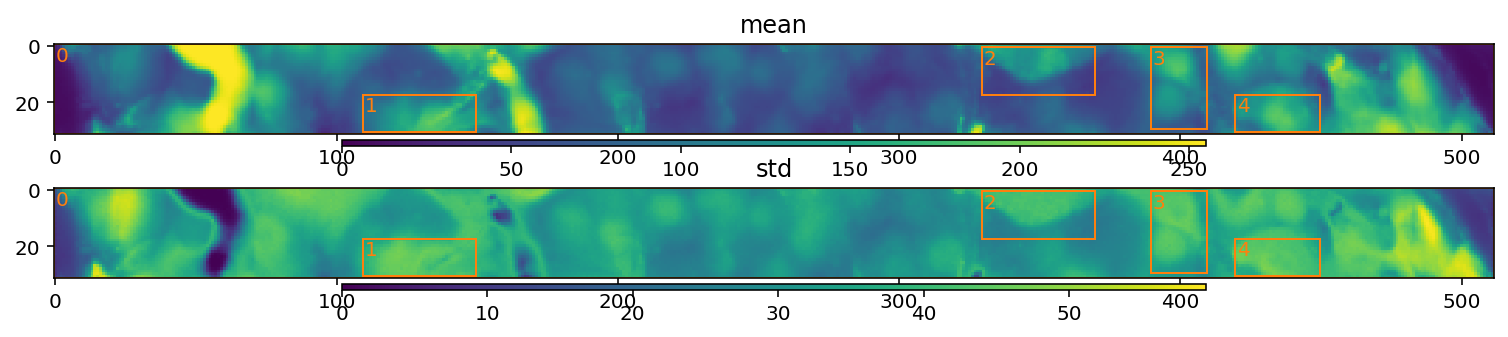

In [42]:
fig = plt.figure(figsize=(10,2))
if showTransposed:
    axs  = [fig.add_axes([  0,.07,1 ,.45]),fig.add_axes([ 0 ,.57, 1,.45]),]
    caxs = [fig.add_axes([0.2,.10,.6,.02]),fig.add_axes([0.2,.60,.6,.02]),]
else:
    axs  = [fig.add_axes([ 0 ,0,.4 ,1]),fig.add_axes([.5 ,0,.4 ,1]),]
    caxs = [fig.add_axes([.41,0,.02,1]),fig.add_axes([.91,0,.02,1]),]


for X,ax,cax,name in zip([timeStd,np.mean(image,axis=0)],axs,caxs,["std","mean"]):
    if not showTransposed:X = X.T
    im_ = ax.imshow(X, vmin=0)
    plt.colorbar(im_, cax=cax,orientation="horizontal")
    ax.set_title(name)
    ir = 0
    for rfname in RFs:
        regionFilter = RFs[rfname]
        roi = Rectangle(
            (regionFilter[0].min()-.5,regionFilter[1].min()-.5),
            width=len(regionFilter[0]),
            height=len(regionFilter[1]),
            fill=False,
            edgecolor="C1"
        )
        ax.add_patch(roi)
        ax.text(regionFilter[0].min(),regionFilter[1].min(),rfname,color="C1",va="top")
        ir+=1


In [43]:
time = np.linspace(0,TotalTime,dimensions["T"])

In [44]:
AllProfiles = OrderedDict()

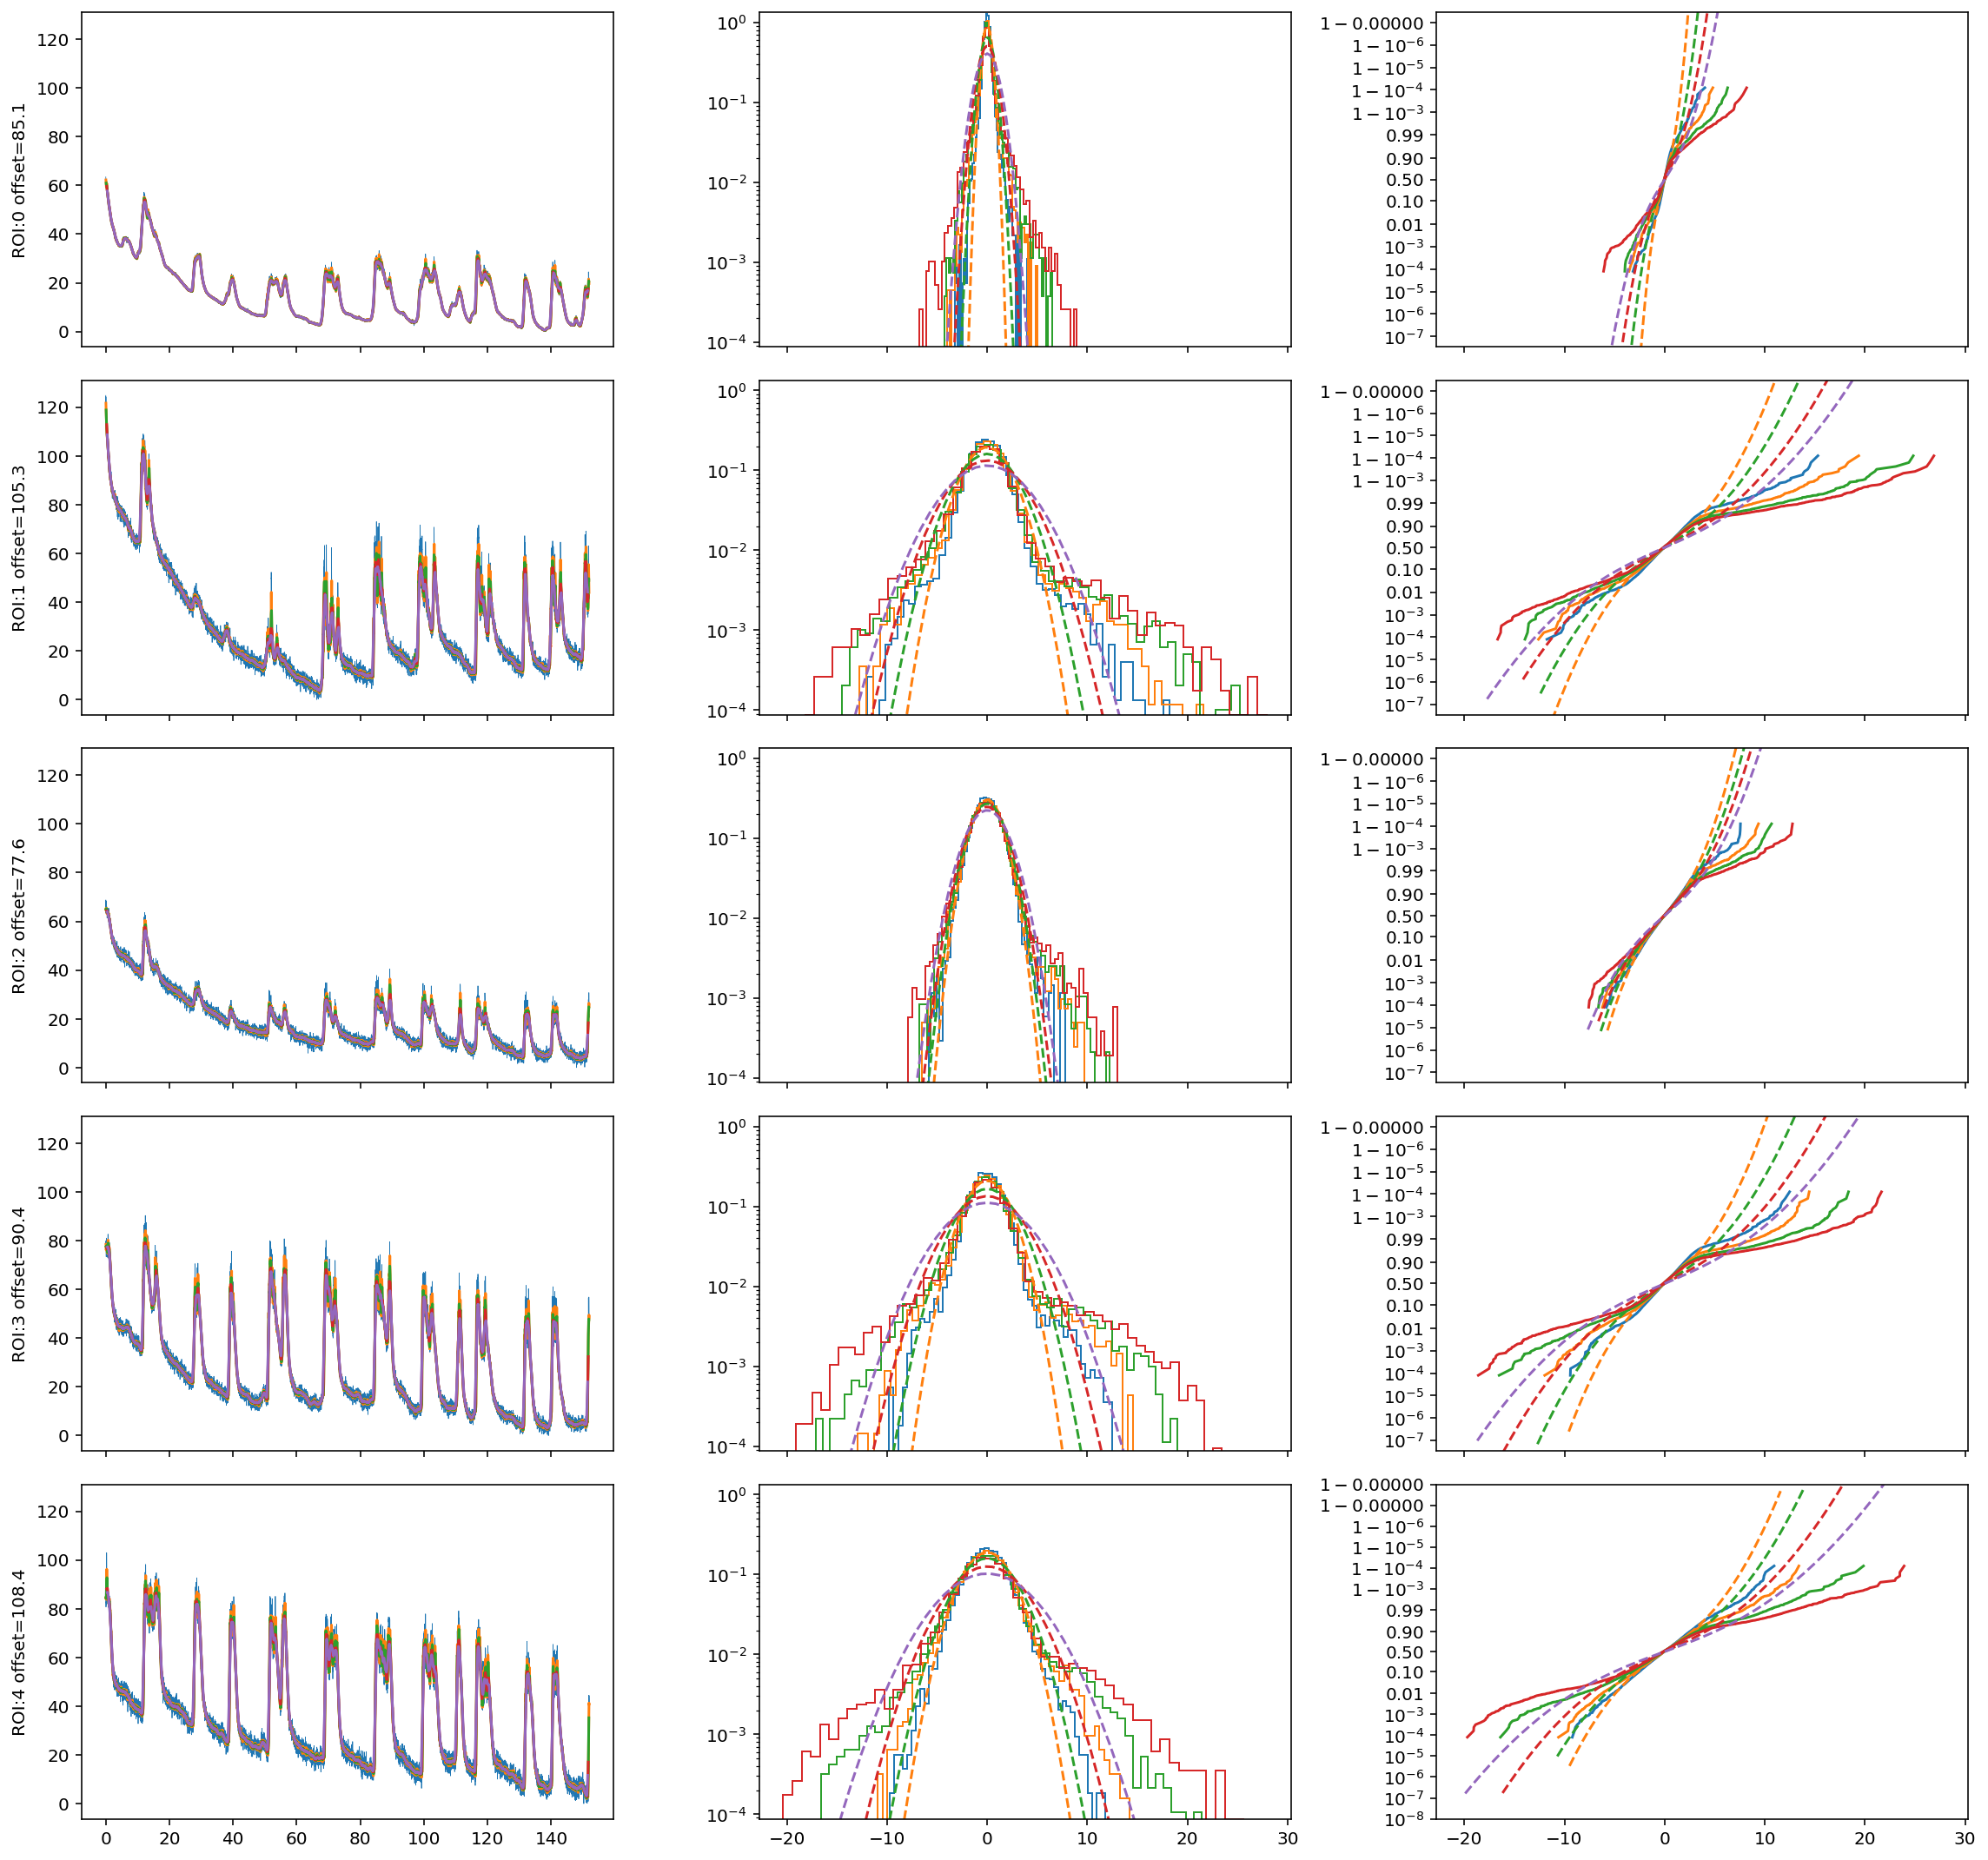

In [45]:
# showRFs = {0:RFs[0]}
showRFs = RFs
fig, Axs = plt.subplots(len(showRFs),3,figsize=(16,3*len(showRFs)), sharex="col", sharey="col")
if len(Axs.shape)==1:
    Axs=Axs.reshape(1,-1)

for ir,rfname in enumerate(showRFs):
    regionFilter = RFs[rfname]
    axs = Axs[ir]
    timeProfile = np.mean(image.T[np.ix_(*regionFilter)].T, axis=(1,2))
    offset = timeProfile.min()
    axs[0].plot(time,timeProfile-offset,lw=.4)
    profileAverages = OrderedDict([("raw",timeProfile)])
    for dtAvg in [10,20,50,80]:
        dtAvg -= 1
        timeProfileAvg = moving_average(timeProfile,dtAvg)
        timeAvg = moving_average(time, dtAvg)
        rest = timeProfile[dtAvg//2:-(dtAvg//2)]-timeProfileAvg
        profileAverages[dtAvg+1] = pd.DataFrame(OrderedDict([
            ("time", timeAvg),
            ("smooth", timeProfileAvg),
            ("rest", rest),
        ]))
        c = axs[0].plot(timeAvg,timeProfileAvg-offset,
#                         label="offset=%.1f"%timeProfileAvg.mean()
                       )[0].get_color()
        yb,bbs,_ = axs[1].hist(rest,50,histtype="step",density=True)
        xb = (bbs[:-1]+bbs[1:])/2
        restStd = rest.std()
        axs[1].plot(xb,dst.norm.pdf(xb,scale=restStd),c=c,ls="--")
        x = rest.copy()
        axs[1].set_ylim(yb[yb>0].min(),)
        axs[2].plot(sorted(x),np.linspace(0,1,len(x)))
        axs[2].plot(xb,dst.norm.cdf(xb,scale=restStd),c=c,ls="--")
#     axs[0].legend()
    axs[0].set_ylabel("ROI:%s offset=%.1f"%(repr(rfname),offset))
    axs[1].set_yscale("log")
    axs[2].set_yscale("logit")
    axs[2].set_yticks(axs[2].get_yticks())
    yx = axs[2].yaxis
    l = yx.get_minor_locator()
    l.minor = False
#     break
    AllProfiles[rfname] = profileAverages
fig.tight_layout()

<IPython.core.display.Javascript object>


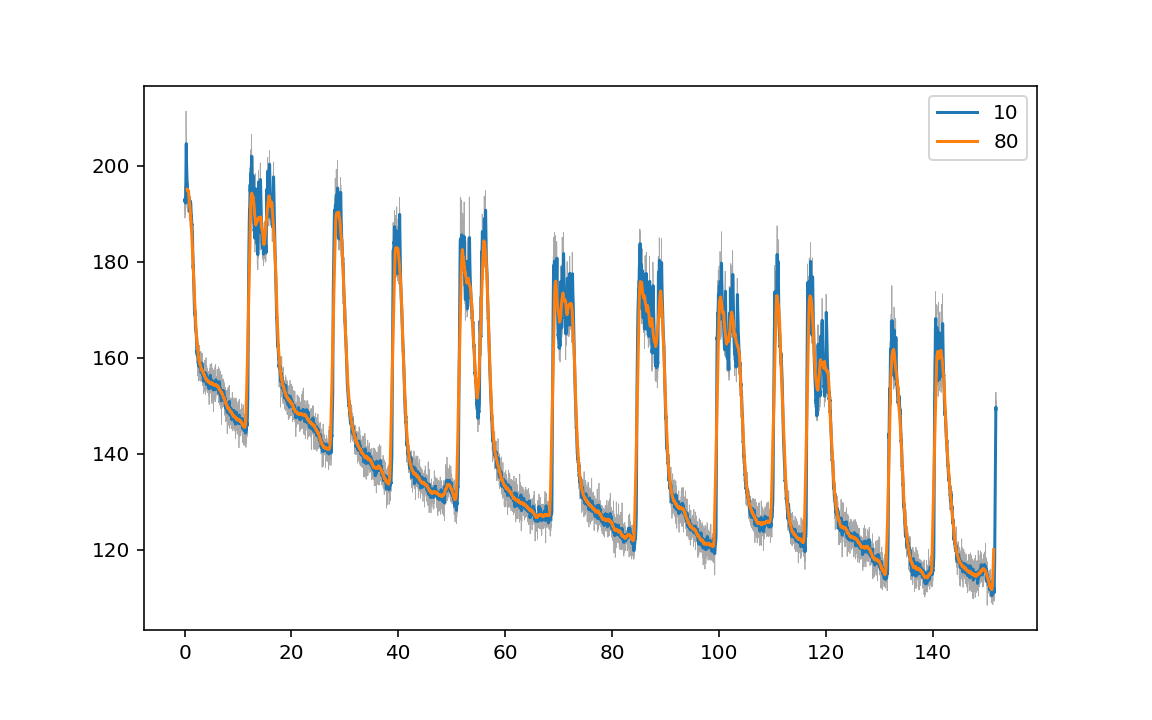

In [47]:
from importlib import reload
reload(plt)
%matplotlib notebook

rfname = 4

plt.figure(figsize=(8,5))

tmp = AllProfiles[rfname]
# for dtAvg in tmp:
for dtAvg in ["raw",10,80]:
    if dtAvg=="raw":
        plt.plot(time,tmp["raw"],color="darkgrey",lw=.4)
    else:
        t,x = tmp[dtAvg][["time","smooth"]].values.T
        plt.plot(t,x,label=dtAvg)
plt.legend()

In [144]:
filename, Name

('Experiment.lif', 'Series052')

## FFT

In [48]:
%matplotlib inline

In [71]:
TotalTime = 20.331 # from Sandra's screenshot

In [118]:
trace1 = tmp["raw"]
trace1 -= trace1.mean()
dt  = TotalTime/len(trace1)
FTs = np.fft.fft(trace1)
N   = len(trace1)
freqs = np.fft.fftfreq(N,dt)
FAs = np.abs(FTs)


In [119]:
PowerSpectrum = FAs**2/(1/dt)**2
print (np.sum(PowerSpectrum)*freqs[1])
print (np.sum(trace1**2)*dt)

71433.8045357824
71433.80453578239


In [120]:
def filterF(x,th=1,h=1):
    return 1/(th**2+x**2)**h

In [121]:

Nshow = N//2
l1 = plt.plot(freqs[:Nshow],PowerSpectrum[:Nshow], label='raw',
              color="darkgreen")
# smooth = 3
# l2 = plt.plot(freqs[smooth//2:Nshow-smooth//2],
#          moving_average(PowerSpectrum[:Nshow], smooth),
#               label='smoothed scale=%i'%smooth, color="indigo")

plt.ylabel('power spectrum')
plt.xlabel('frequency (Hz)')
# plt.xlim(2*freqs[1],10.**3.9)
plt.yscale('log')
plt.xscale('log')
plt.twinx()
# plt.xlim(2*freqs[1],10.**3.9)

xr = np.logspace(-2,2.1, 201)

l3 = plt.plot(xr,filterF(xr), label="filter", color="red", ls="--",lw=2)
plt.ylabel('single pole filter')

# lns = l1+l2+l3
# labs = [l.get_label() for l in lns]
# plt.legend(lns, labs, loc=3)
plt.legend()

In [100]:
from importlib import reload
reload(plt)

<IPython.core.display.Javascript object>


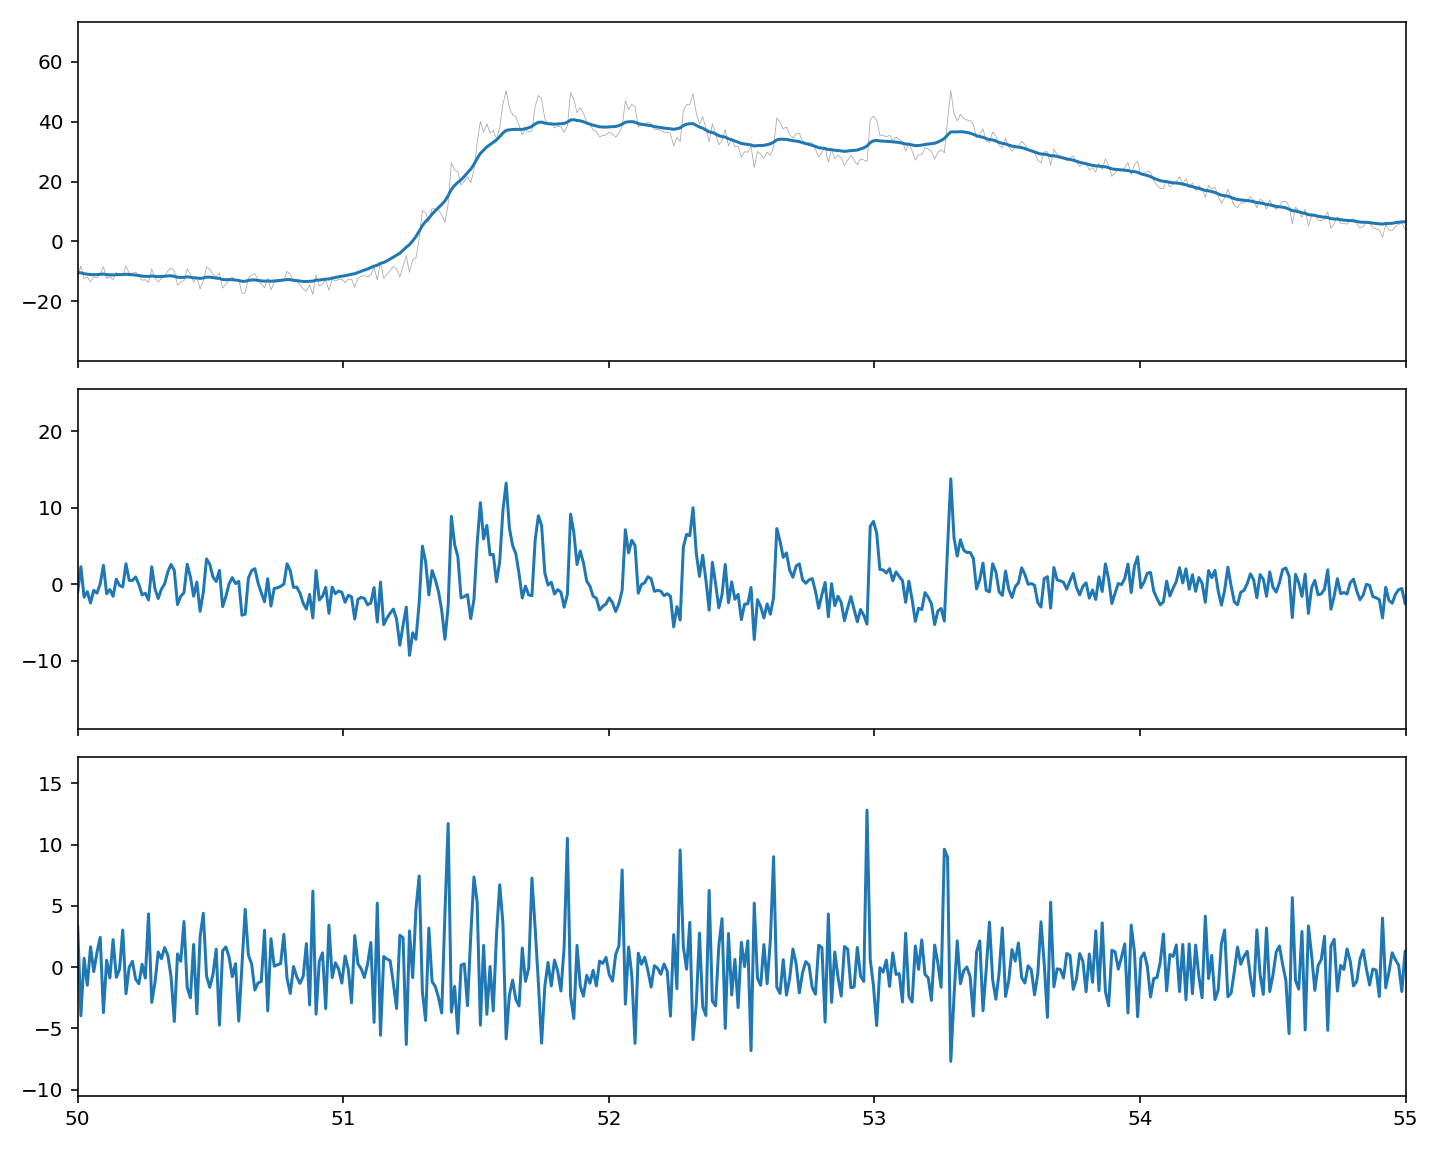

In [145]:
%matplotlib notebook
fig, axs = plt.subplots(3,1,figsize=(10,8), sharex=True)
axs[0].plot(time,trace1,color="darkgrey",lw=.4)

for th in [1]:
    filteredFT = FTs*filterF(freqs,th=th)**.5
    filteredTrace = np.real_if_close(np.fft.ifft(filteredFT))
    axs[0].plot(time,filteredTrace)
    axs[1].plot(time,trace1-filteredTrace)
#     axs[2].plot(time[:-1],np.diff(trace1))
    axs[2].plot(time[:-1],np.diff(trace1-filteredTrace))

axs[1].set_xlim(50,55)
fig.tight_layout()

<IPython.core.display.Javascript object>


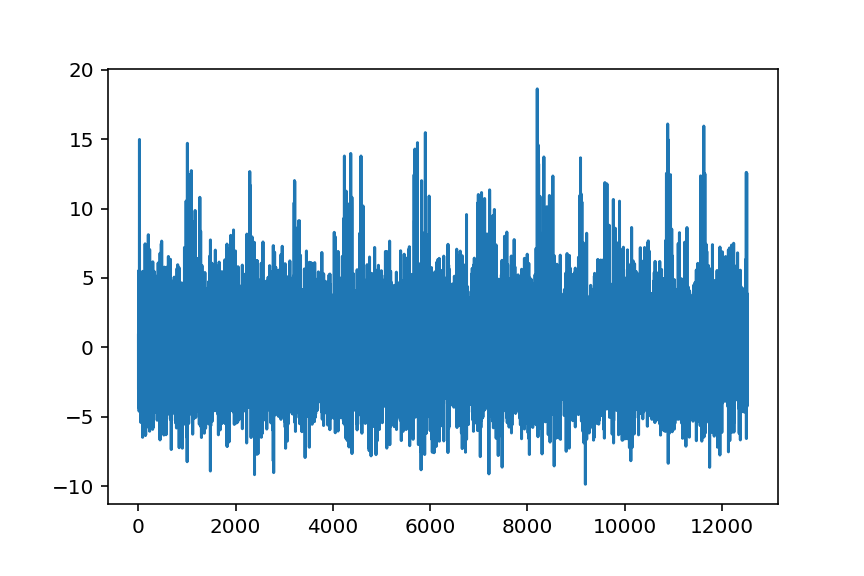

In [141]:
%matplotlib notebook
plt.plot(np.diff(trace1))

In [185]:
filteredTrace.shape, trace1.shape

((685,), (685,))

In [103]:
# "freq" in 
k = list(constFeatures.keys())[0]
k.lower(),np.isin(["inc","|"],k.lower())

('channeldescription|bitinc', array([False, False]))

In [117]:
fltrkeys = [
        "freq",
        "time",
        "dwell",
#         "length",
        "delay",
        "expo",
        "gain",
        "integ",
]
pd.concat([
    mdf.loc[idx],
    features.loc[Name,[c for c in features.columns if np.any([l in c.lower() for l in fltrkeys])]],
    pd.Series(OrderedDict([(k.replace("|"," | "),v) for k,v in constFeatures.items() if np.any([l in k.lower() for l in fltrkeys])])),
])

Name                                                                                      Series051
AcquisitionDate                                                                 2019-05-16 14:14:16
X                                                                                               512
Y                                                                                                32
T                                                                                             12524
C                                                                                                 1
Z                                                                                                 1
nAverageLine_1                                                                                    3
HardwareSetting|FilterSettingRecord|HyD 1 (Gain) #1                                              24
HardwareSetting|FilterSettingRecord|X Reson. Scan Actuator (Gain) #1                        3.09594


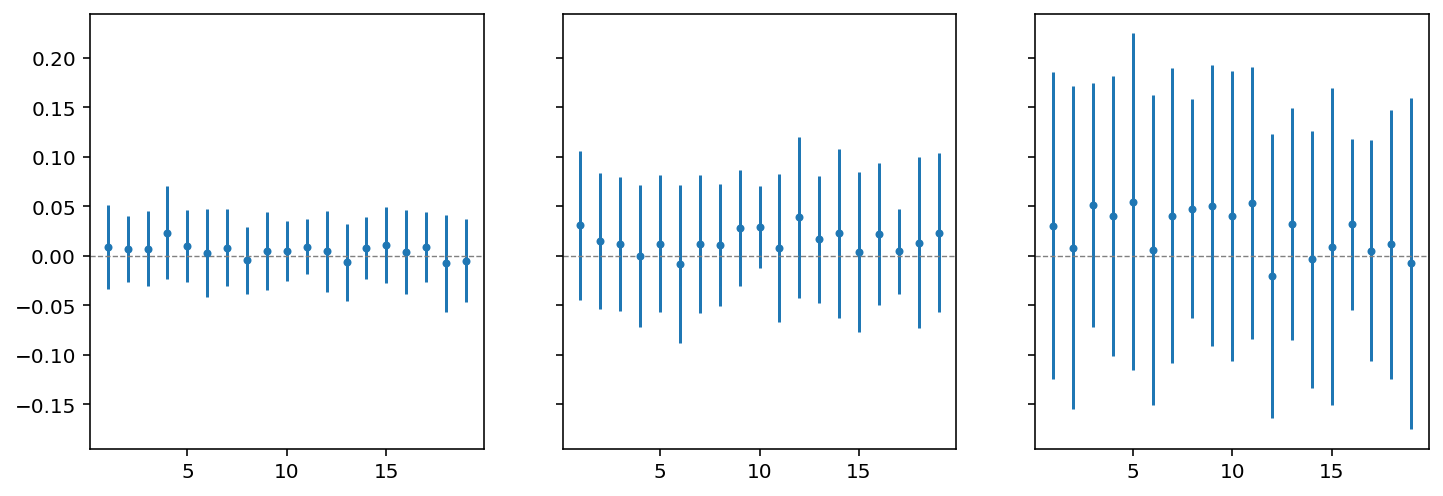

In [331]:
xr = np.arange(1,20)
dtBin = 3
nc = 3
fig, axs = plt.subplots(1,nc,figsize=(nc*4,4), sharex=True, sharey=True)
for i in range(nc):
    ax = axs.flat[i]
#     plt.subplot(1,nc,i+1)
    if i==0:
        X = timeProfile.copy()
    else:
        nTime = len(X)
        X = X[:nTime//dtBin*dtBin].reshape(nTime//dtBin,dtBin).mean(axis=1)
    yr, ye = autocorr(X, xr,nsplits=20)
    ax.errorbar(xr,yr,ye,ls="none",marker=".")
    ax.axhline(0,color='grey', ls="--", lw=.7)
#     plt.show()

(-13.190000000000001, 268.19)

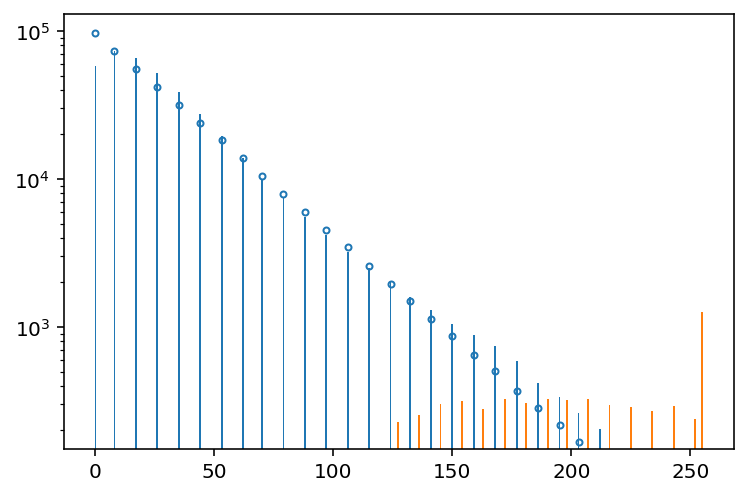

In [51]:


realxx = dst.expon.rvs(scale=3.6,size=(2,int(1e6)))
for xx in [
    (realxx.flatten()  .astype( int)*8.865).astype(int),
]:
    xr,yr = np.array(tally(xx)).T
    plt.plot(xr,yr/yr.sum()*y.sum(),".", mfc="none")

    
ims_r = ims[:,:,1:-1]
xr,yr = np.array(tally(ims_r[~np.isin(ims_r,xr)].flatten())).T


plt.bar(xr,yr)
# # plt.bar(xr,yr/yr.sum()*1,color="C2")

plt.xlim(xl)

<BarContainer object of 7 artists>

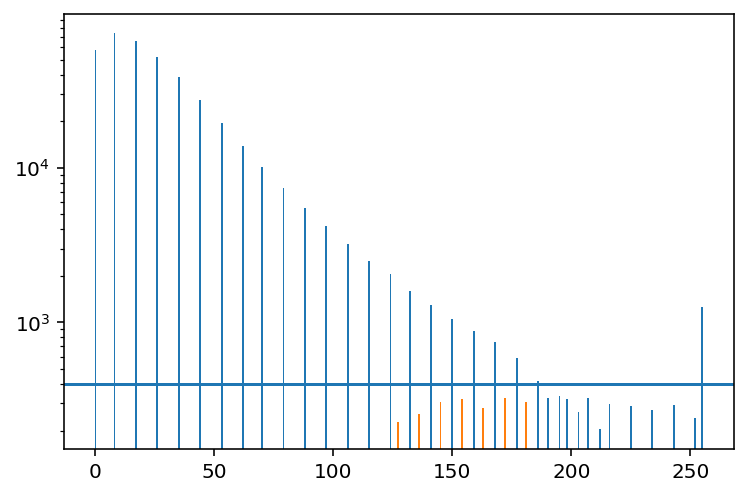

In [48]:
th = 4e2
plt.axhline(th)
take = x[y<th]
take = take[take<190]

tmp = tmp[np.isin(tmp,take)]
x,y = np.array(tally(tmp)).T
plt.bar(x,y)

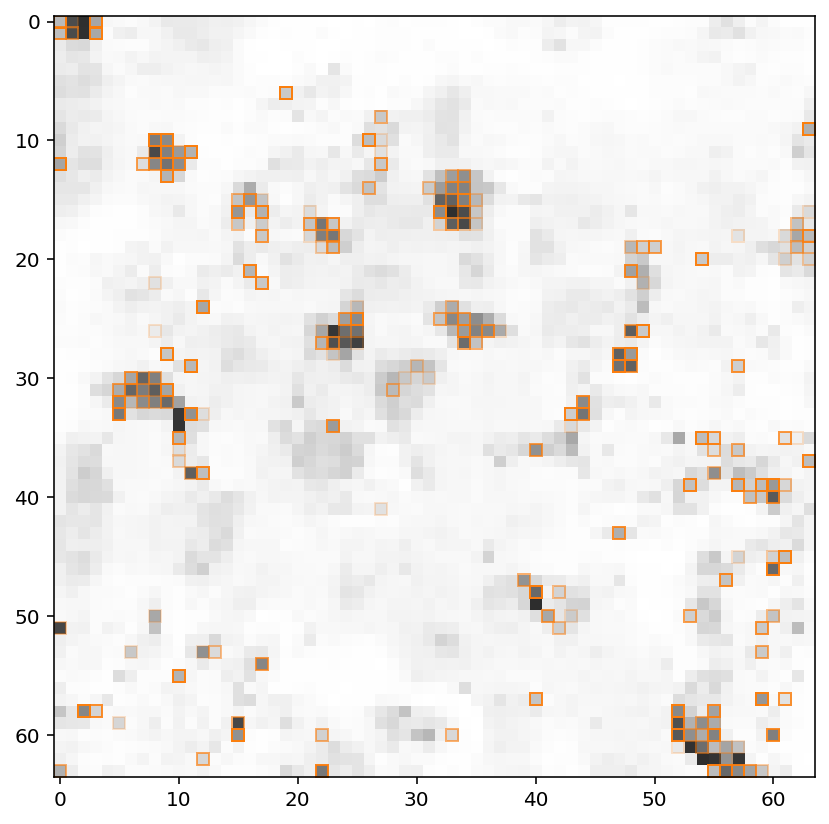

In [49]:
plt.figure(figsize=(7,7))
plt.imshow(np.mean(ims,axis=0).T, cmap="Greys",vmax=300)
for t,x,y in zip(*np.where(np.isin(ims,take))):
    plt.plot(x,y,"C1s",
             alpha = .2,
             mfc="none"
            )
    #, )#,mec="C1")

In [85]:
from scipy.stats import distributions as dst

(-13.190000000000001, 268.19)

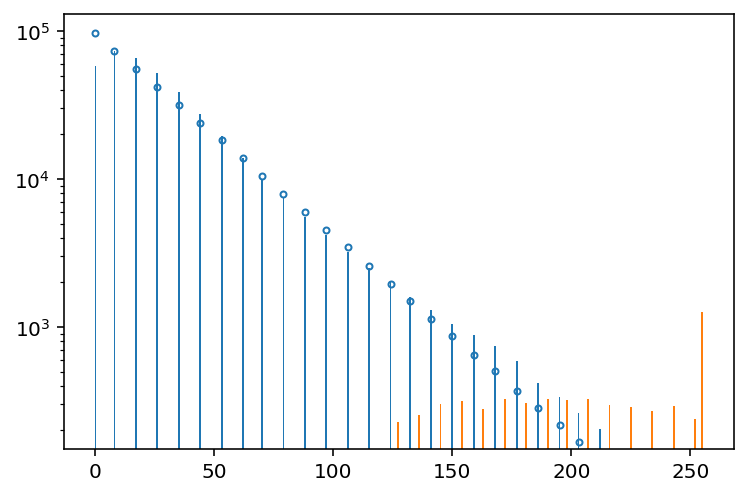

In [51]:
# x,y = np.array(tally(ims.flatten())).T
# plt.bar(x,y)

x,y = np.array(tally(ims.T[1:-1].flatten())).T
plt.bar(x,y)

plt.yscale("log")
xl = plt.xlim()

realxx = dst.expon.rvs(scale=3.6,size=(2,int(1e6)))
for xx in [
    (realxx.flatten()  .astype( int)*8.865).astype(int),
]:
    xr,yr = np.array(tally(xx)).T
    plt.plot(xr,yr/yr.sum()*y.sum(),".", mfc="none")

    
ims_r = ims[:,:,1:-1]
xr,yr = np.array(tally(ims_r[~np.isin(ims_r,xr)].flatten())).T


plt.bar(xr,yr)
# # plt.bar(xr,yr/yr.sum()*1,color="C2")

plt.xlim(xl)

In [52]:
take = xr

In [53]:
imsf = ims.astype(float)

In [54]:
imsf[~np.isin(imsf,take)] = np.nan

/Users/srdjan/anaconda2/envs/physio/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


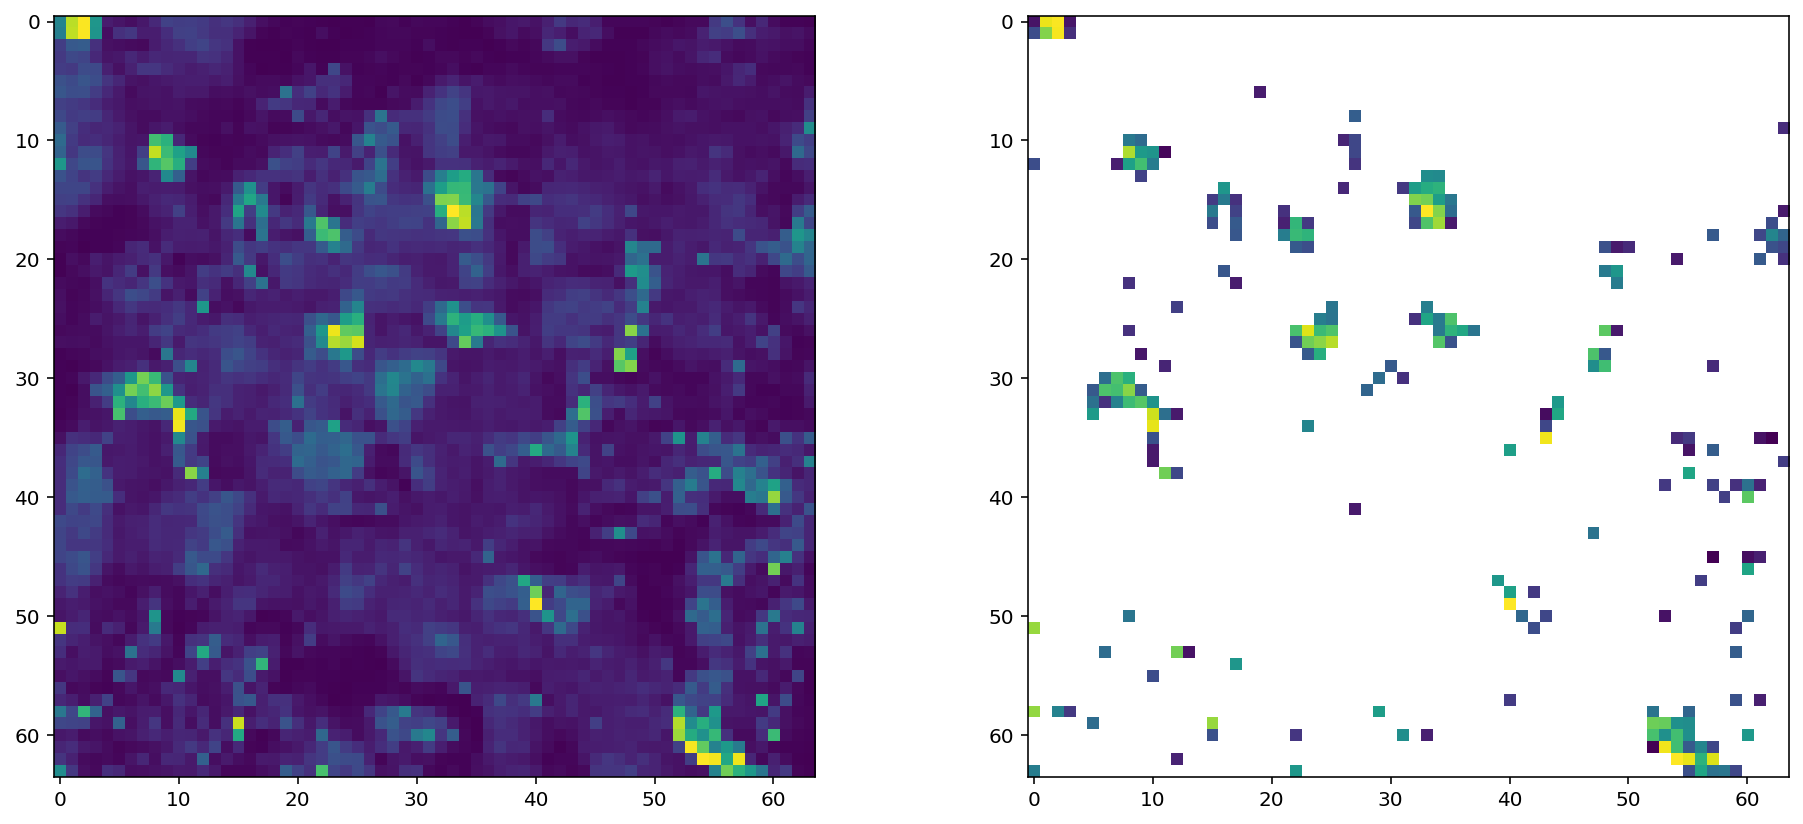

In [55]:
fig,axs = plt.subplots(1,2,figsize=(16,7))
axs[0].imshow(np.nanmean(ims ,axis=0).T)
axs[1].imshow(np.nanmean(imsf,axis=0).T)
# for t,x,y in zip(*np.where(np.isin(ims[::1000],take))):
#     plt.plot(x,y,"C1s",
#              alpha = .2,
#              mfc="none"
#             )
#     #, )#,mec="C1")

# Kill javabridge

In [ ]:
javabridge.kill_vm()